In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor
import utils as u
from sklearn.metrics import classification_report

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


c:\Users\andre\miniconda3\envs\crypto-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading meme data

In [2]:
gaming = pd.read_csv('../data/processed/gaming.csv')
ai = pd.read_csv('../data/processed/ai.csv')
meme = pd.read_csv('../data/processed/meme.csv')
rwa = pd.read_csv('../data/processed/rwa.csv')

gaming.shape, ai.shape, meme.shape, rwa.shape

((125654, 10), (113423, 10), (33039, 10), (52339, 10))

## Preprocessing data

In [3]:
days_to_predict = 7

In [4]:
class category_data:
    def __init__(self, train_data, test_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler):
        self.train_data = train_data
        self.test_data = test_data
        self.series_dict = series_dict
        self.exog_dict = exog_dict
        self.future_exog_dict = future_exog_dict
        self.series_scaler = series_scaler
        self.exog_scaler = exog_scaler
        self.forecaster = None
        self.predictions = None
        self.og_train = None
        self.og_test = None
        self.og_pred = None
        self.error_df = None
        self.close_df = None

In [5]:
def generate_data_object(data: pd.DataFrame, days: int):
    train_data, test_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler = u.preprocess(data, days_to_predict=7)
    data_obj = category_data(train_data, test_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler)
    return data_obj

In [6]:
gaming_obj = generate_data_object(gaming, days_to_predict)
ai_obj = generate_data_object(ai, days_to_predict)
meme_obj = generate_data_object(meme, days_to_predict)
rwa_obj = generate_data_object(rwa, days_to_predict)

In [7]:
gaming_obj.forecaster = u.train_best_forecaster(gaming_obj.series_dict, gaming_obj.exog_dict, gaming_obj.future_exog_dict, gaming_obj.test_data, future_days=days_to_predict)
ai_obj.forecaster = u.train_best_forecaster(ai_obj.series_dict, ai_obj.exog_dict, ai_obj.future_exog_dict, ai_obj.test_data, future_days=days_to_predict)
meme_obj.forecaster = u.train_best_forecaster(meme_obj.series_dict, meme_obj.exog_dict, meme_obj.future_exog_dict, meme_obj.test_data, future_days=days_to_predict)
rwa_obj.forecaster = u.train_best_forecaster(rwa_obj.series_dict, rwa_obj.exog_dict, rwa_obj.future_exog_dict, rwa_obj.test_data, future_days=days_to_predict)

Training model with parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 5, 'min_split_gain': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3885
[LightGBM] [Info] Number of data points in the train set: 80319, number of used features: 16
[LightGBM] [Info] Start training from score -0.008433
Training model with parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 5, 'min_split_gain': 0.001, 'n_estimators': 100, 'num_leaves': 63, 'subsample': 1.0}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total

In [8]:
gaming_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=gaming_obj.forecaster, future_exog_dict=gaming_obj.future_exog_dict)
ai_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=ai_obj.forecaster, future_exog_dict=ai_obj.future_exog_dict)
meme_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=meme_obj.forecaster, future_exog_dict=meme_obj.future_exog_dict)
rwa_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=rwa_obj.forecaster, future_exog_dict=rwa_obj.future_exog_dict)

In [9]:
gaming_obj.og_train, gaming_obj.og_test, gaming_obj.og_pred = u.inverse_scaling(train_df=gaming_obj.train_data, test_df=gaming_obj.test_data, pred_df=gaming_obj.predictions, scalers=gaming_obj.series_scaler)
ai_obj.og_train, ai_obj.og_test, ai_obj.og_pred = u.inverse_scaling(train_df=ai_obj.train_data, test_df=ai_obj.test_data, pred_df=ai_obj.predictions, scalers=ai_obj.series_scaler)
meme_obj.og_train, meme_obj.og_test, meme_obj.og_pred = u.inverse_scaling(train_df=meme_obj.train_data, test_df=meme_obj.test_data, pred_df=meme_obj.predictions, scalers=meme_obj.series_scaler)
rwa_obj.og_train, rwa_obj.og_test, rwa_obj.og_pred = u.inverse_scaling(train_df=rwa_obj.train_data, test_df=rwa_obj.test_data, pred_df=rwa_obj.predictions, scalers=rwa_obj.series_scaler)

In [10]:
gaming_obj.close_df = u.get_last_close_info(gaming_obj.og_train, gaming_obj.og_test, gaming_obj.og_pred)
ai_obj.close_df = u.get_last_close_info(ai_obj.og_train, ai_obj.og_test, ai_obj.og_pred)
meme_obj.close_df = u.get_last_close_info(meme_obj.og_train, meme_obj.og_test, meme_obj.og_pred)
rwa_obj.close_df = u.get_last_close_info(rwa_obj.og_train, rwa_obj.og_test, rwa_obj.og_pred)

In [11]:
print("Gaming")
print(classification_report(gaming_obj.close_df['real_went_up'], gaming_obj.close_df['pred_went_up']))
print("AI")
print(classification_report(ai_obj.close_df['real_went_up'], ai_obj.close_df['pred_went_up']))
print("Meme")
print(classification_report(meme_obj.close_df['real_went_up'], meme_obj.close_df['pred_went_up']))
print("RWA")
print(classification_report(rwa_obj.close_df['real_went_up'], rwa_obj.close_df['pred_went_up']))

Gaming
              precision    recall  f1-score   support

         0.0       0.20      0.12      0.15         8
         1.0       0.87      0.92      0.89        50

    accuracy                           0.81        58
   macro avg       0.53      0.52      0.52        58
weighted avg       0.78      0.81      0.79        58

AI
              precision    recall  f1-score   support

         0.0       0.33      0.20      0.25        10
         1.0       0.68      0.81      0.74        21

    accuracy                           0.61        31
   macro avg       0.51      0.50      0.49        31
weighted avg       0.57      0.61      0.58        31

Meme
              precision    recall  f1-score   support

         0.0       0.33      0.12      0.18         8
         1.0       0.53      0.80      0.64        10

    accuracy                           0.50        18
   macro avg       0.43      0.46      0.41        18
weighted avg       0.44      0.50      0.44        18

RWA


In [12]:
gaming_obj.error_df = u.compute_errors(train_data=gaming_obj.og_train, predictions_x_days=gaming_obj.og_pred, test_data=gaming_obj.og_test)
ai_obj.error_df = u.compute_errors(train_data=ai_obj.og_train, predictions_x_days=ai_obj.og_pred, test_data=ai_obj.og_test)
meme_obj.error_df = u.compute_errors(train_data=meme_obj.og_train, predictions_x_days=meme_obj.og_pred, test_data=meme_obj.og_test)
rwa_obj.error_df = u.compute_errors(train_data=rwa_obj.og_train, predictions_x_days=rwa_obj.og_pred, test_data=rwa_obj.og_test)

In [13]:
ai_obj.error_df

Token ID           MSE       MAE        MAPE  \
0   050cd820-2c82-4222-892c-e6f2859625c7  7.044528e-09  0.000077   15.838990   
1   0bb97d30-b5bb-45d6-b105-e49436cace0e  1.123349e-04  0.009568    2.909237   
2   0d1428e8-2b88-4314-9b1e-aa664b34a5fe  2.388476e-05  0.004653   71.467920   
3   172a1e9a-f56c-4386-85e1-093d801e4e93  2.173746e-06  0.001191    3.234942   
4   18b987bb-2597-4288-a28e-08d7dbce2ee2  5.551473e-07  0.000686   38.753542   
5   196199f6-1c8f-4be4-83dd-733866d6d558  9.029122e-11  0.000009   32.725694   
6   1e389c02-0a09-4b57-9c50-3a74bca12e4f  4.145790e-02  0.191869    3.577756   
7   1f34fd87-5598-40e7-ac78-7efd6bd28bdd  8.084941e-05  0.008389   11.226442   
8   22820bda-48eb-45bd-b189-af3253ab57c0  3.683855e-06  0.001469    7.766969   
9   3ee65bec-c8c8-482d-ba5c-5c594cc86f2f  1.235090e-05  0.003469   27.001813   
10  42876b1c-10af-47c9-a4f9-853fc207f7b0  9.498137e-06  0.003045  138.062900   
11  490aeb9f-fdf1-4bea-a002-2b294cff0454  3.310279e-05  0.004678    4.293701   
12  5416e814-8023-4f66-aadb-a063afca2414  8.954480e-02  0.260656    5.562971   
13  68221f51-660f-4bed-88e4-680165a9be0c  1.440402e-03  0.033476    6.355663   
14  6a44ac10-0d34-4cf2-a947-53d8bdd54f10  1.317717e-06  0.000935    4.047500   
15  6f67ca1a-5a43-449c-847e-5cfac8d98744  2.581484e-03  0.040632    2.673302   
16  8b88329d-a168-4590-a664-110db3c90308  6.551315e-05  0.007098   12.843848   
17  8cce4515-ed44-4d09-9092-7aef3d046e95  5.511051e-08  0.000198    3.242695   
18  8d807555-a3fa-493c-82bb-fea5c93082f0  1.030368e-07  0.000311   14.150214   
19  978aa54d-1bbb-4f73-bac4-ba7507c27a76  1.218899e-04  0.009284    5.461044   
20  9bb73af8-6ad9-4825-b17c-4ccc6a8fbcf8  4.966108e-08  0.000207    6.983880   
21  a8b53d2d-a2fd-4586-ba67-345e182cc919  2.313135e-04  0.012637    6.714577   
22  aaaac613-ebb5-4af0-ab62-1675cf0a8b8a  1.213242e-06  0.000835    1.947800   
23  aeca591d-3294-42de-bb85-c6a484bacd96  1.153132e-01  0.293488    3.460238   
24  b262d7bb-23ec-475c-8104-c5088e787cb4  2.111378e-06  0.001378   21.085075   
25  b2d068ec-fbd5-4884-beb0-7ad884773733  1.851878e-07  0.000418   19.280046   
26  bc49d919-2925-472d-8bef-e189c0059ccc  2.981737e-01  0.491797    3.360780   
27  d0811fcb-3fcc-41e5-b0f6-cd996b40721e  6.788995e-03  0.078958   31.800844   
28  d1f48a57-2c48-4512-abd6-90e8c29e5aba  4.776073e-03  0.059831    4.162634   
29  ddb361c5-0827-4324-a9ba-ee4fdbf475d9  2.535954e-03  0.036896    2.954185   
30  f59f39ff-5230-42bb-acce-7767dc84cd83  5.620251e-06  0.002161   28.375953   

   MAPE (%)  
0    15.84%  
1     2.91%  
2    71.47%  
3     3.23%  
4    38.75%  
5    32.73%  
6     3.58%  
7    11.23%  
8     7.77%  
9    27.00%  
10  138.06%  
11    4.29%  
12    5.56%  
13    6.36%  
14    4.05%  
15    2.67%  
16   12.84%  
17    3.24%  
18   14.15%  
19    5.46%  
20    6.98%  
21    6.71%  
22    1.95%  
23    3.46%  
24   21.09%  
25   19.28%  
26    3.36%  
27   31.80%  
28    4.16%  
29    2.95%  
30   28.38%

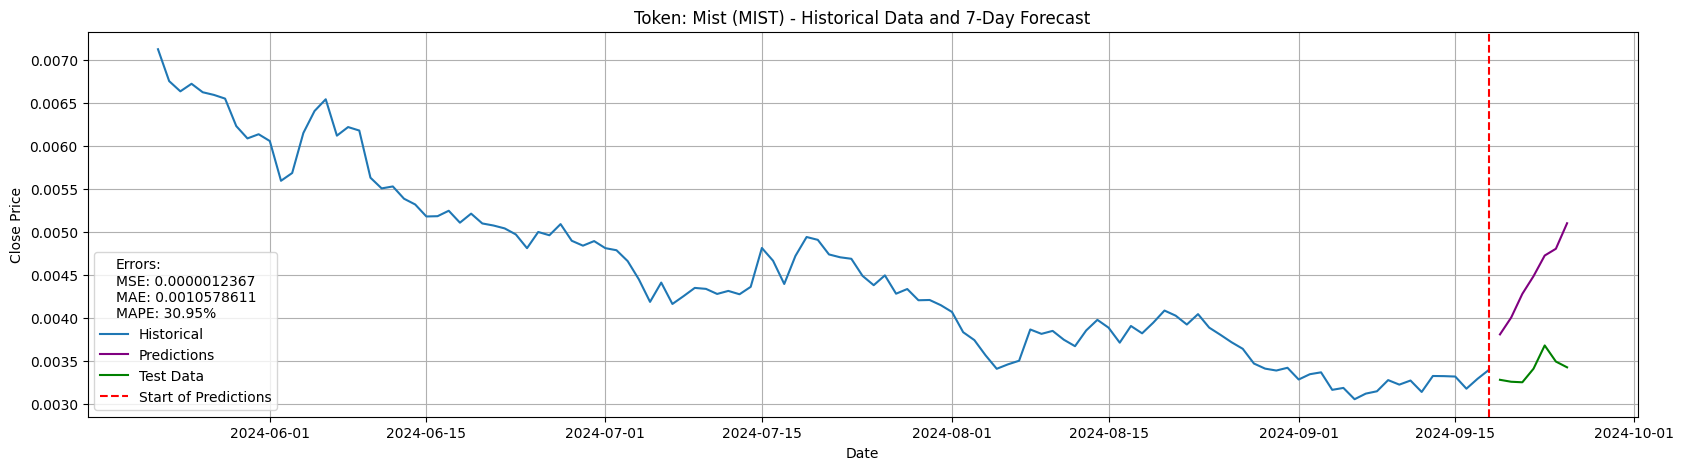

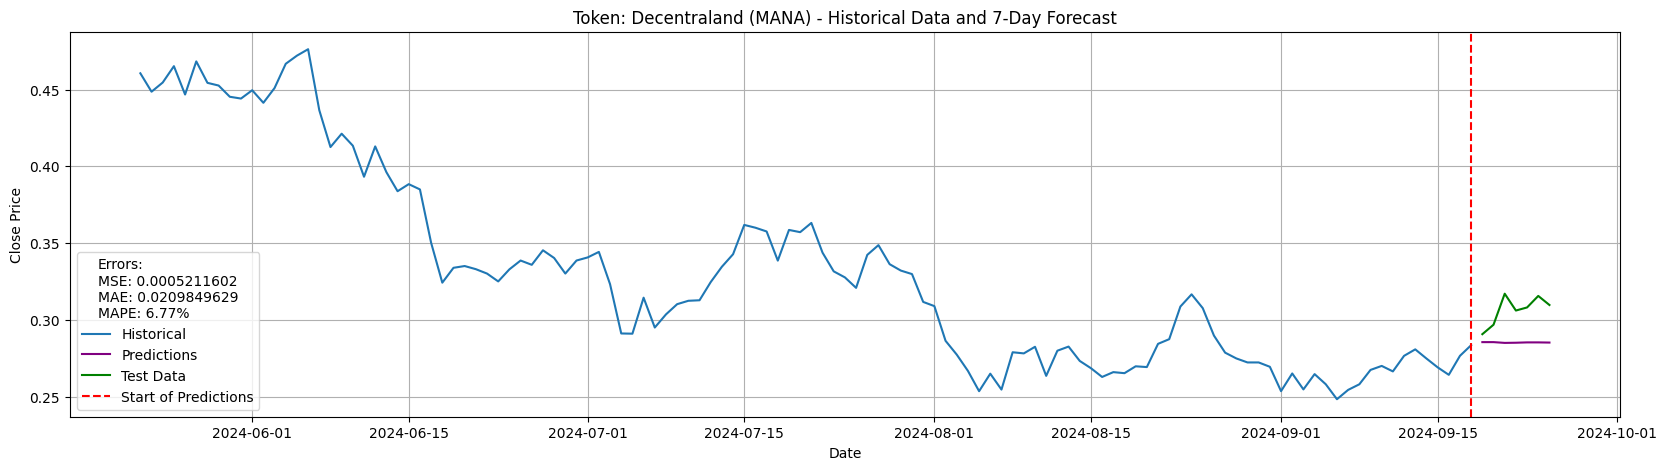

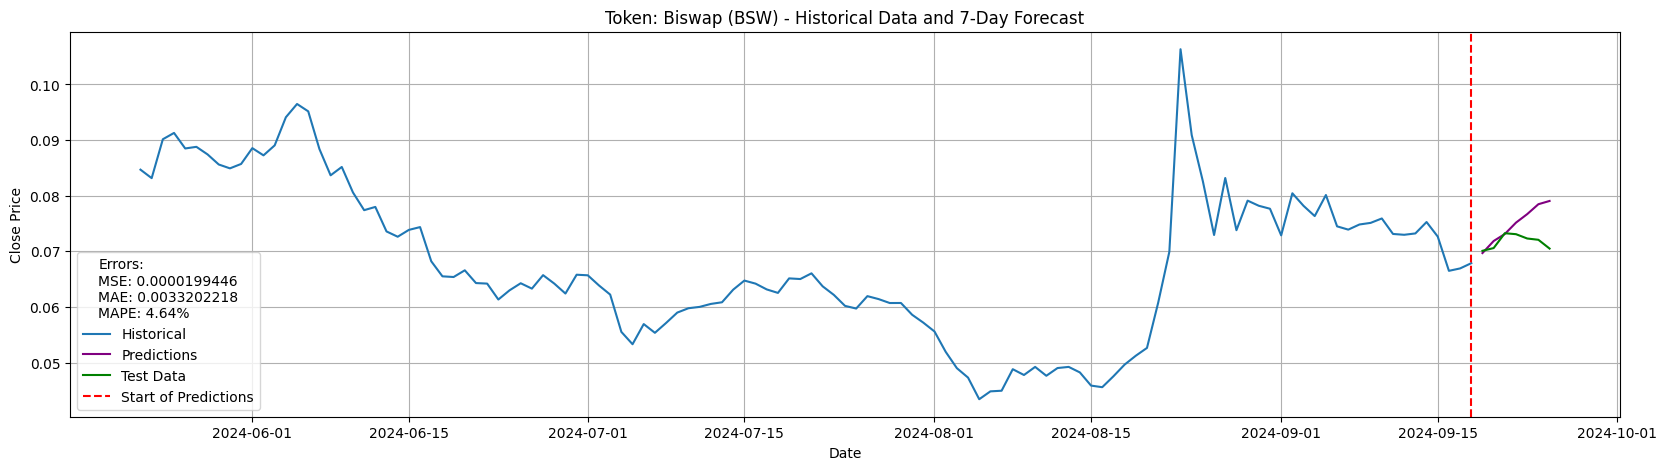

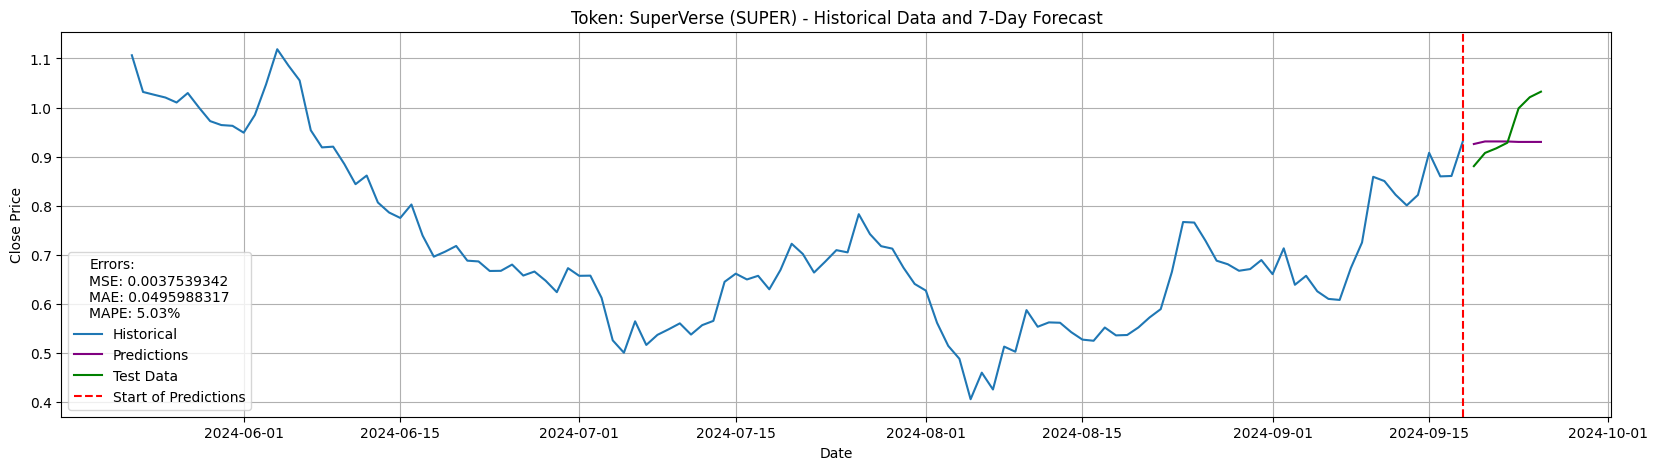

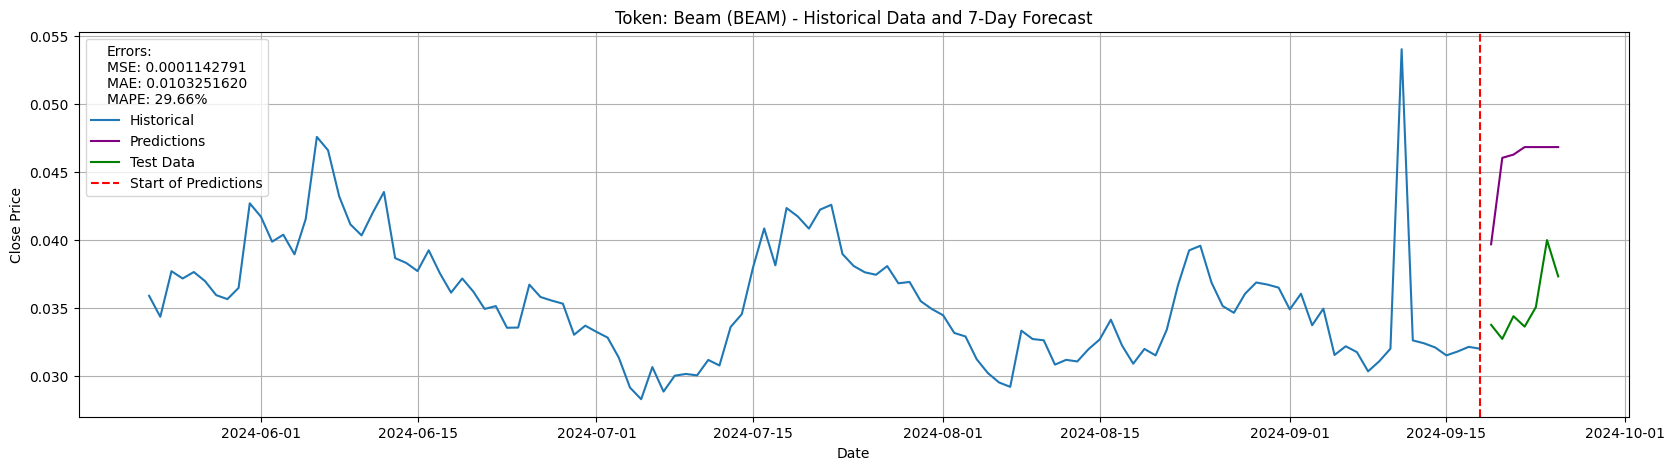

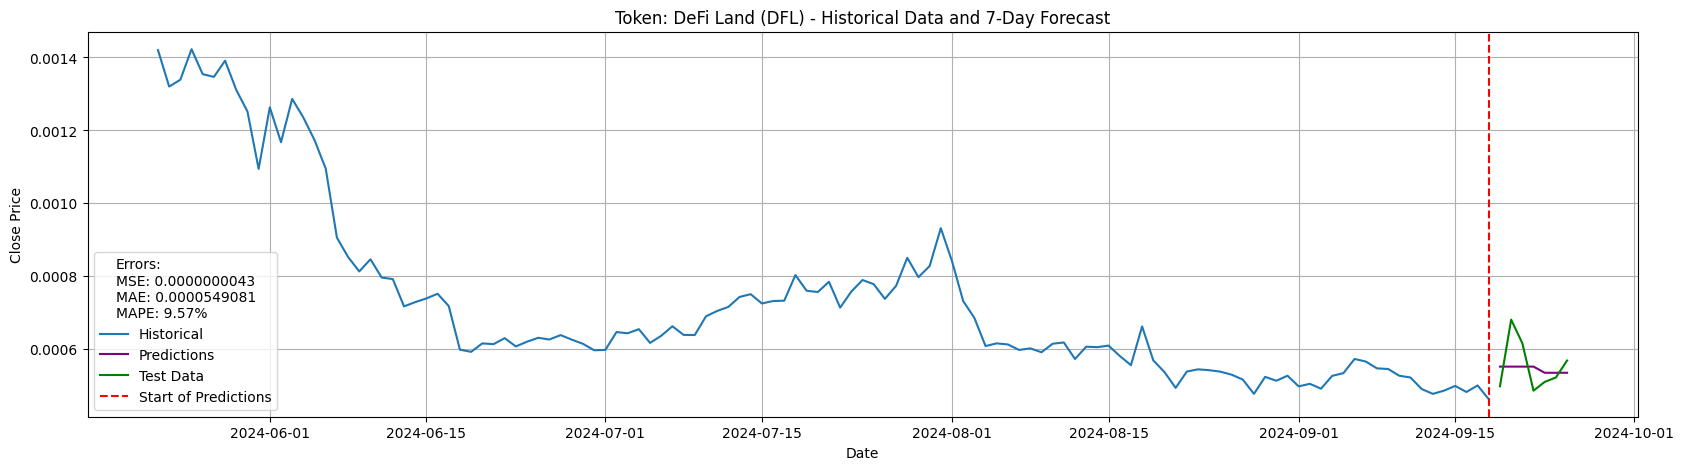

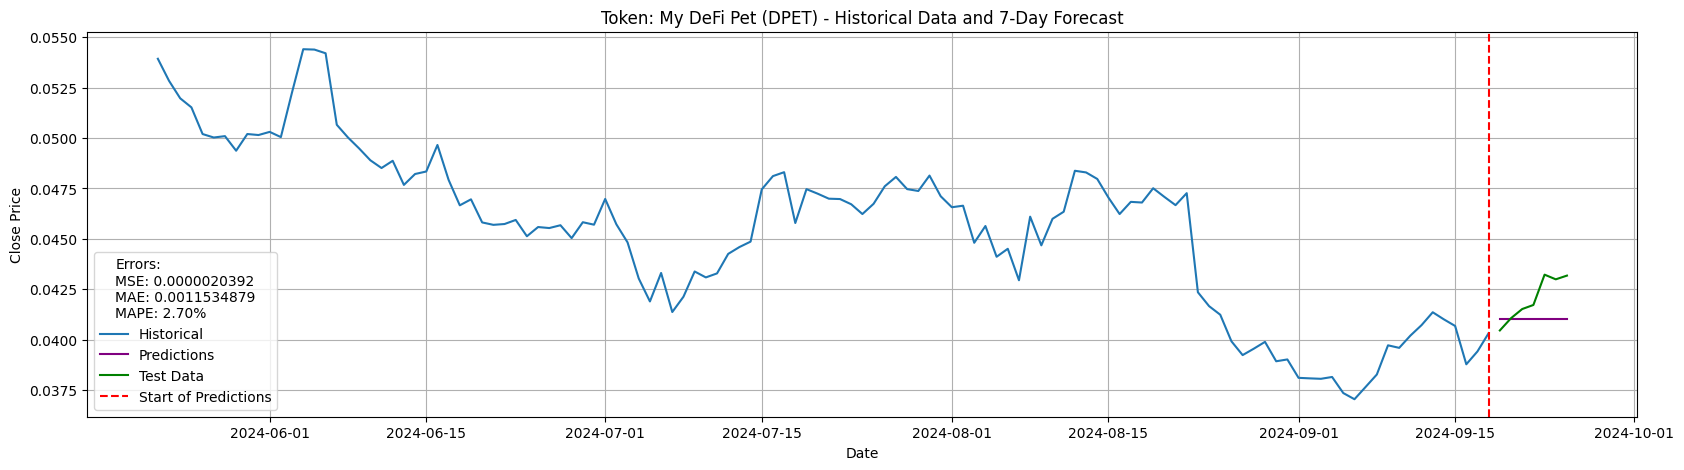

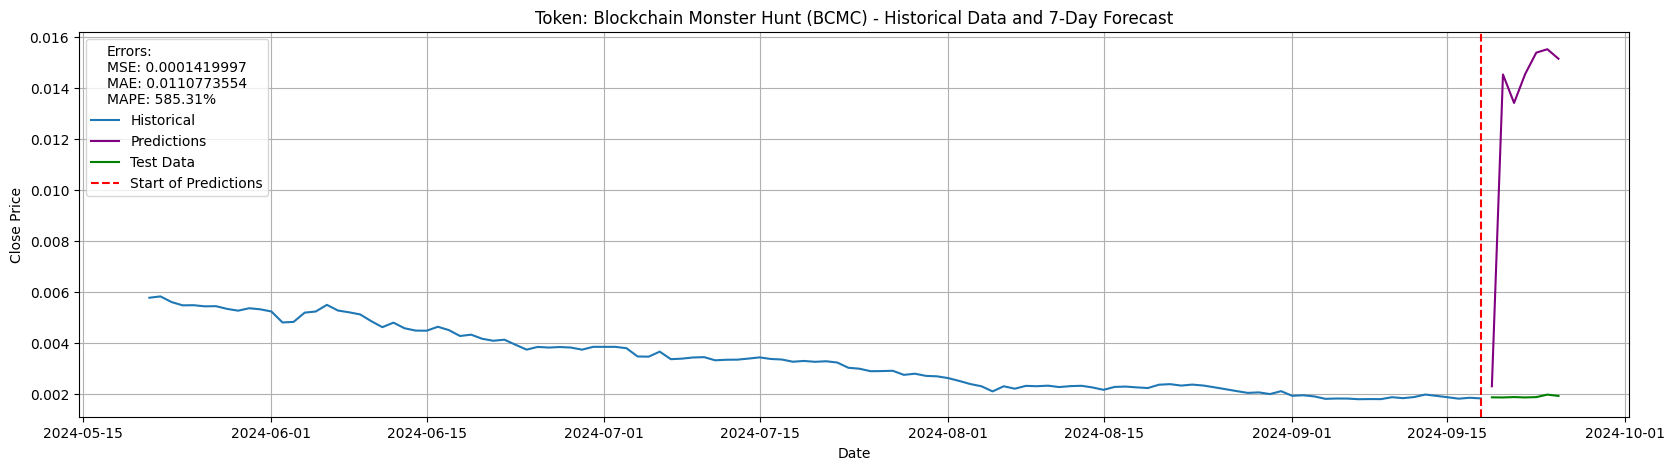

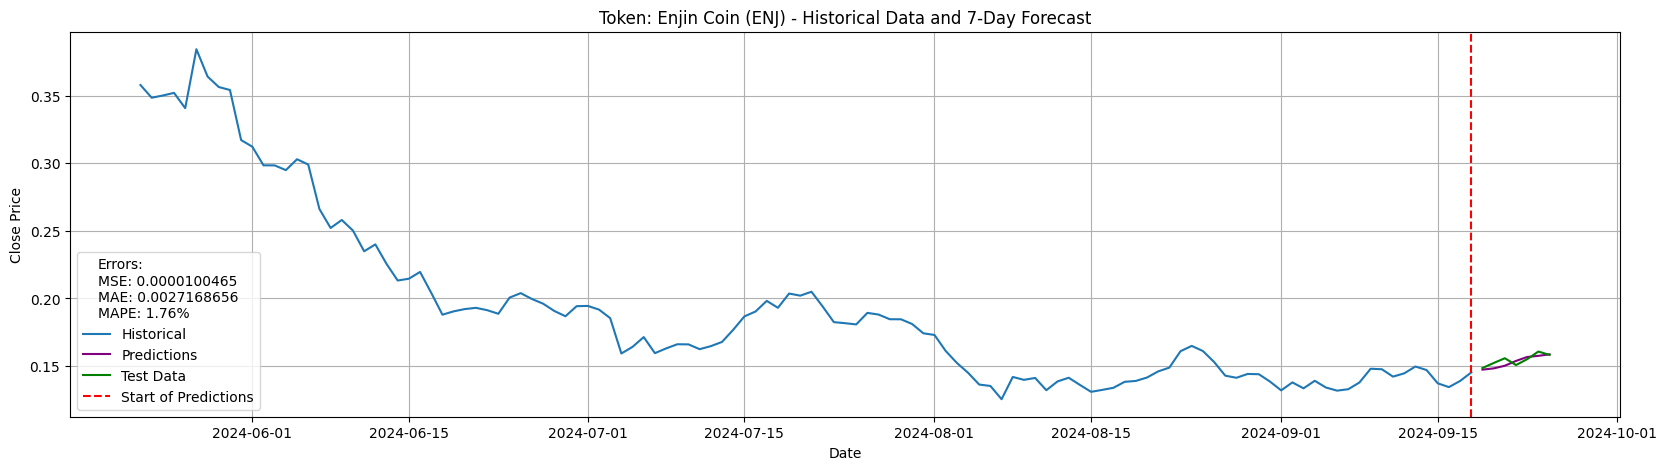

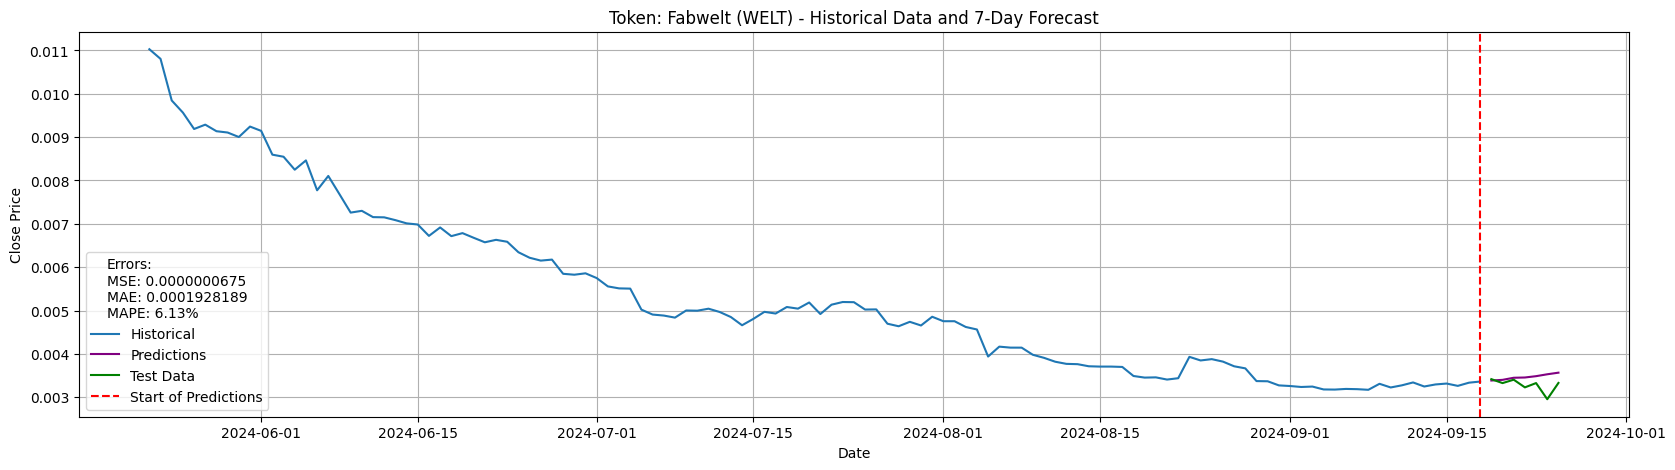

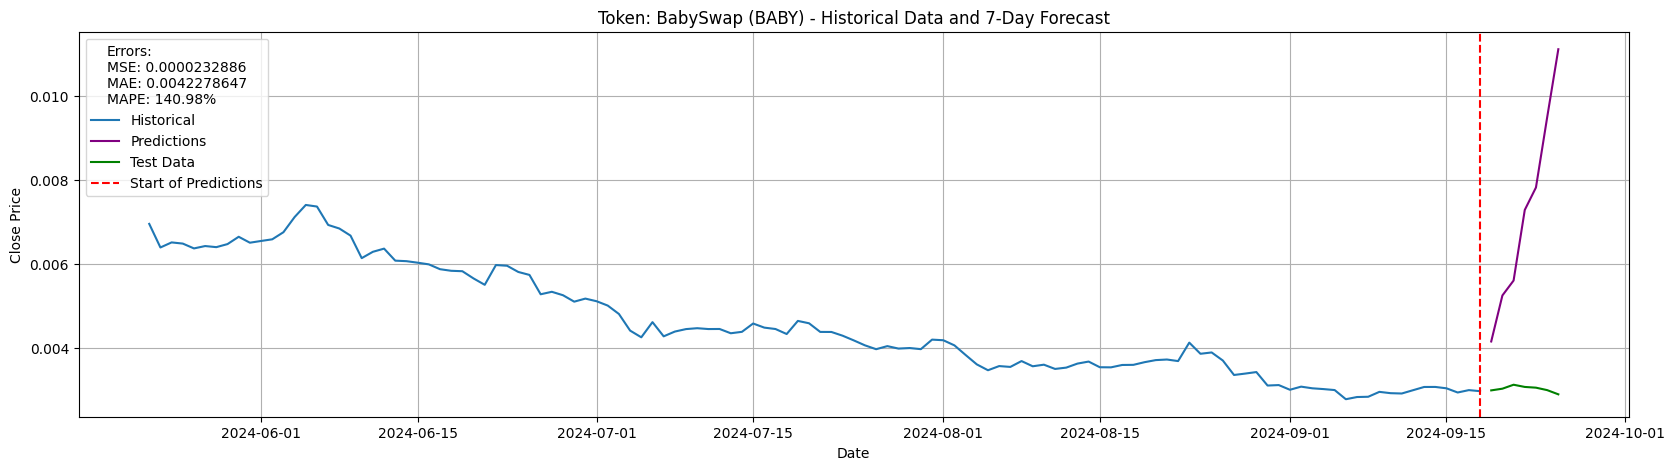

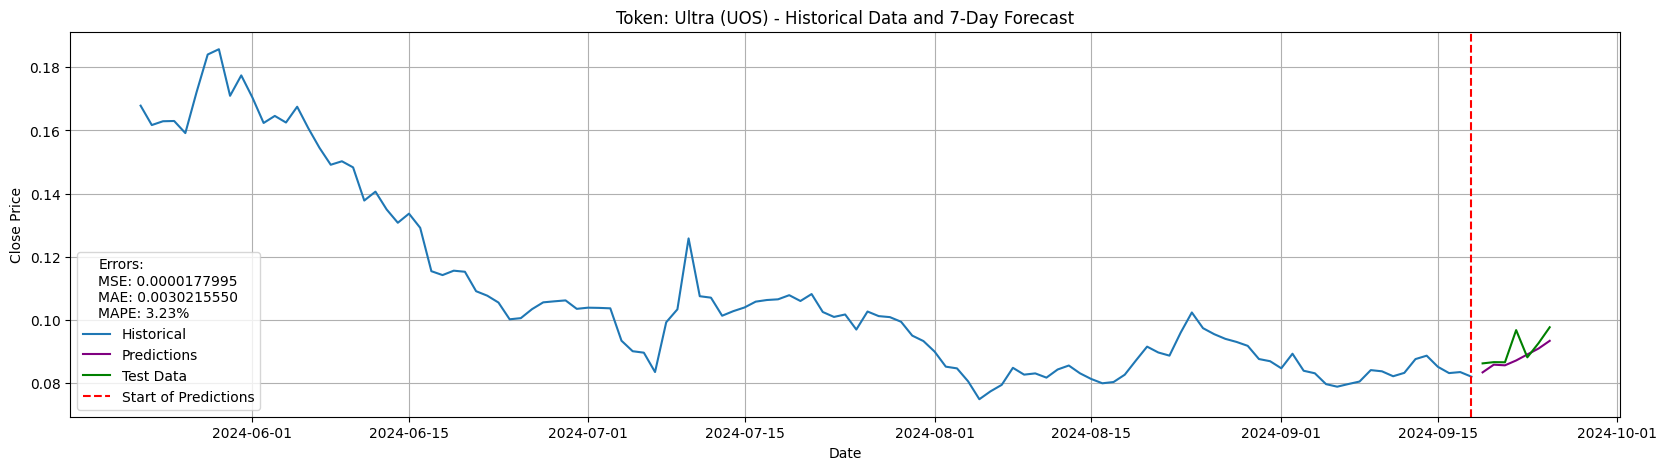

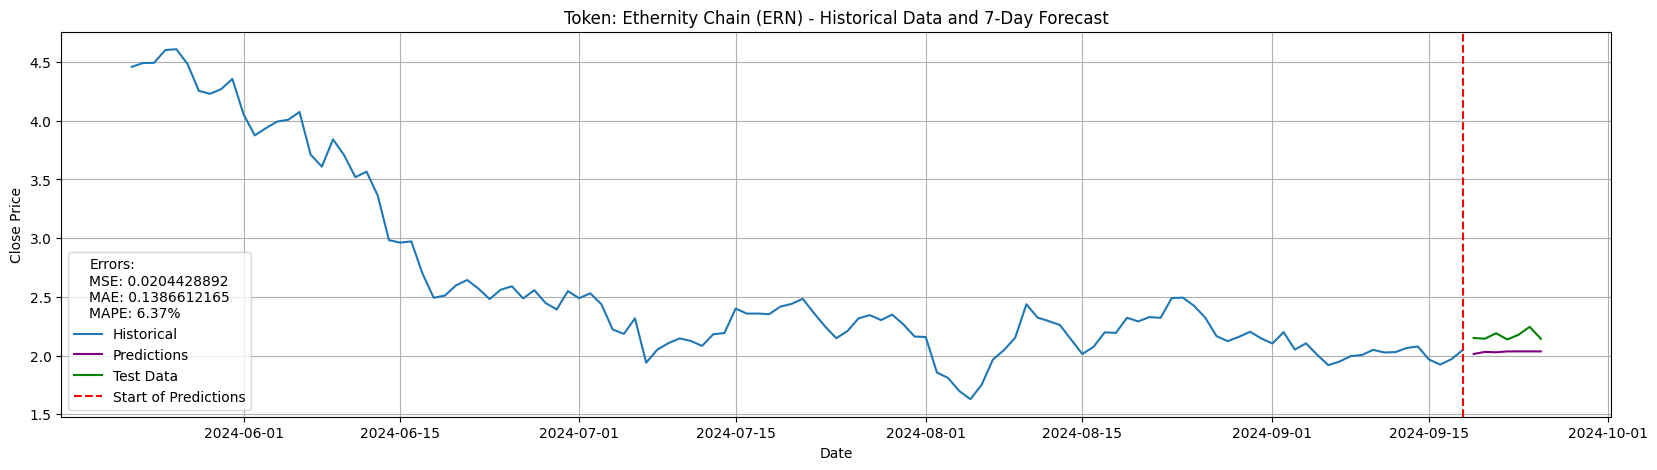

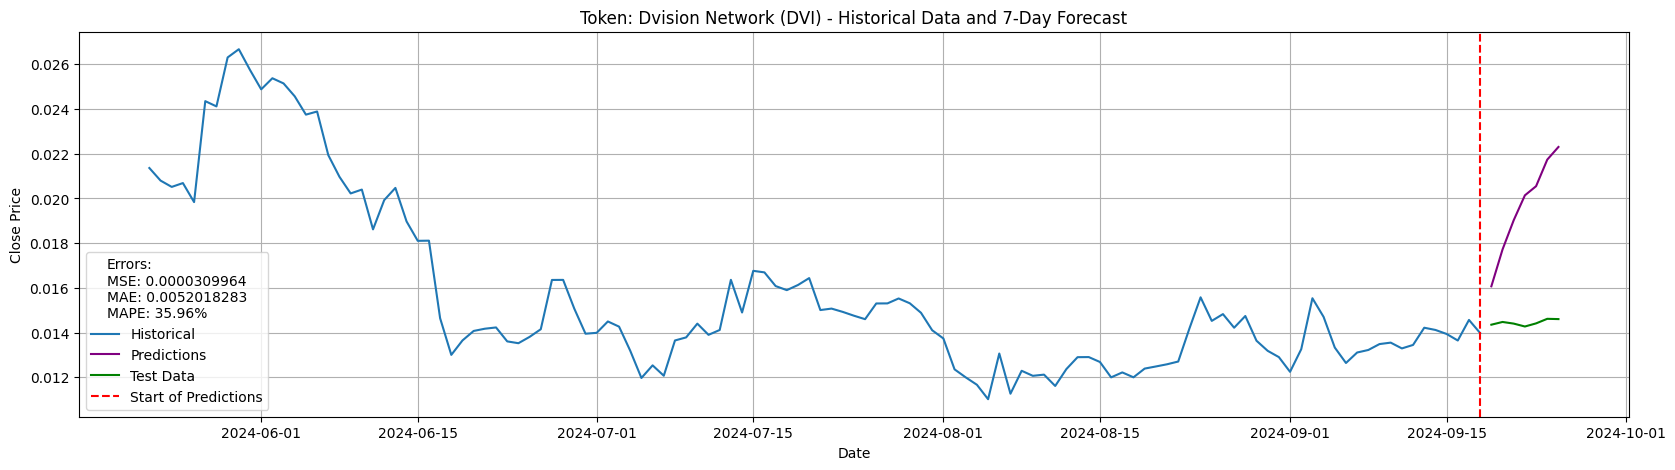

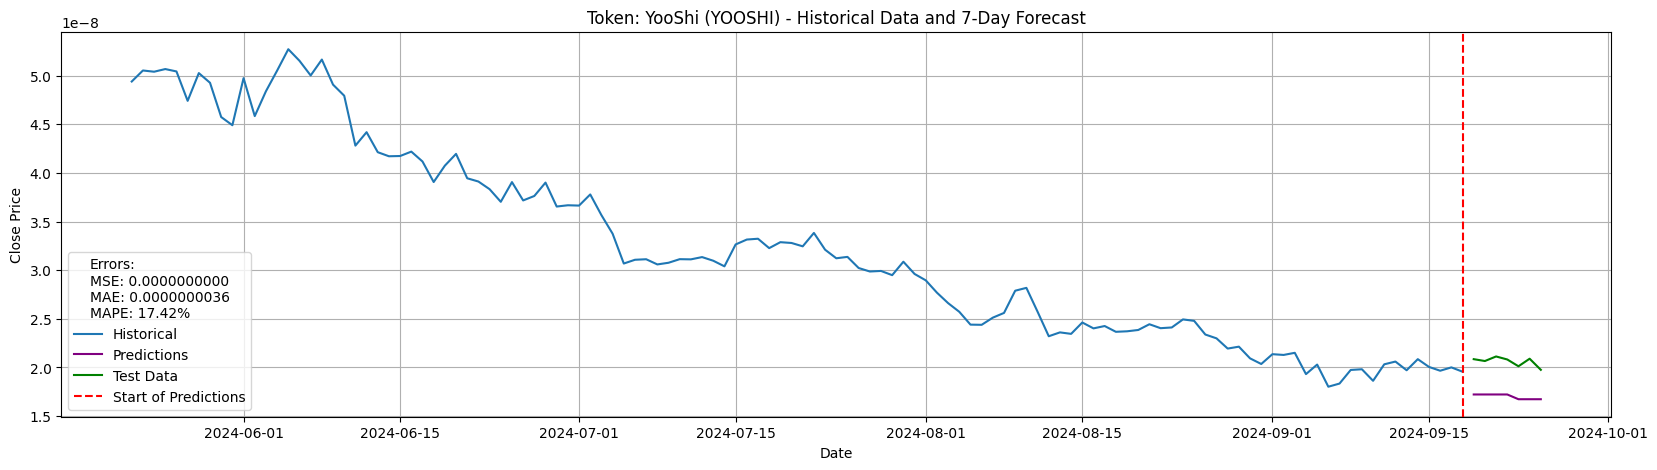

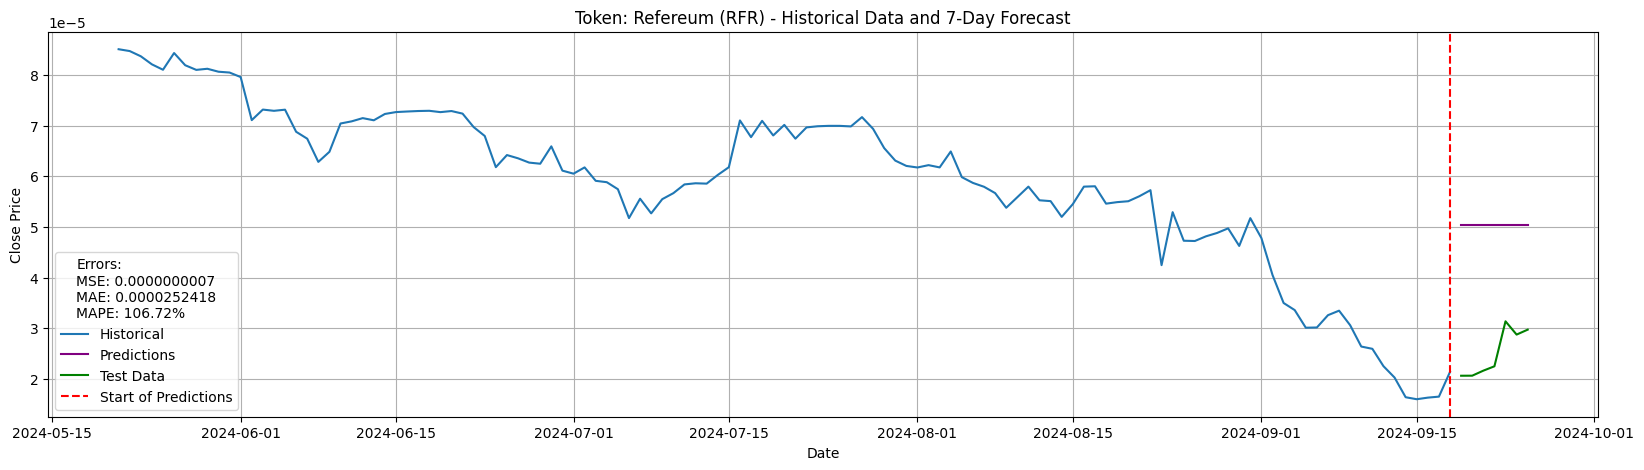

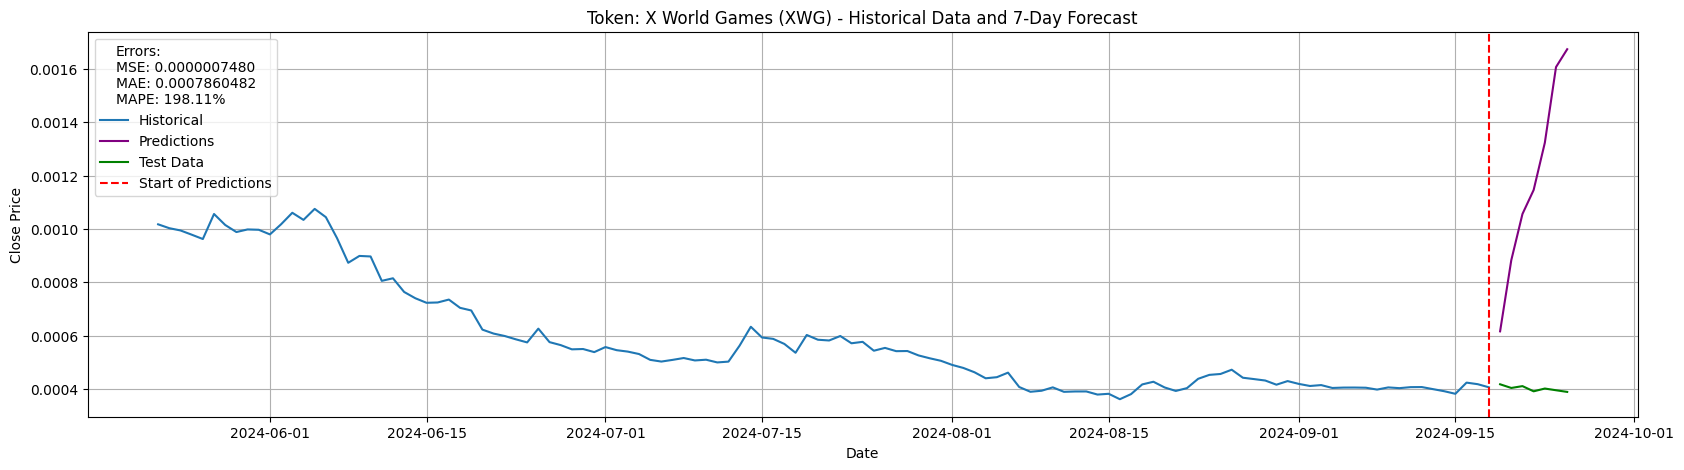

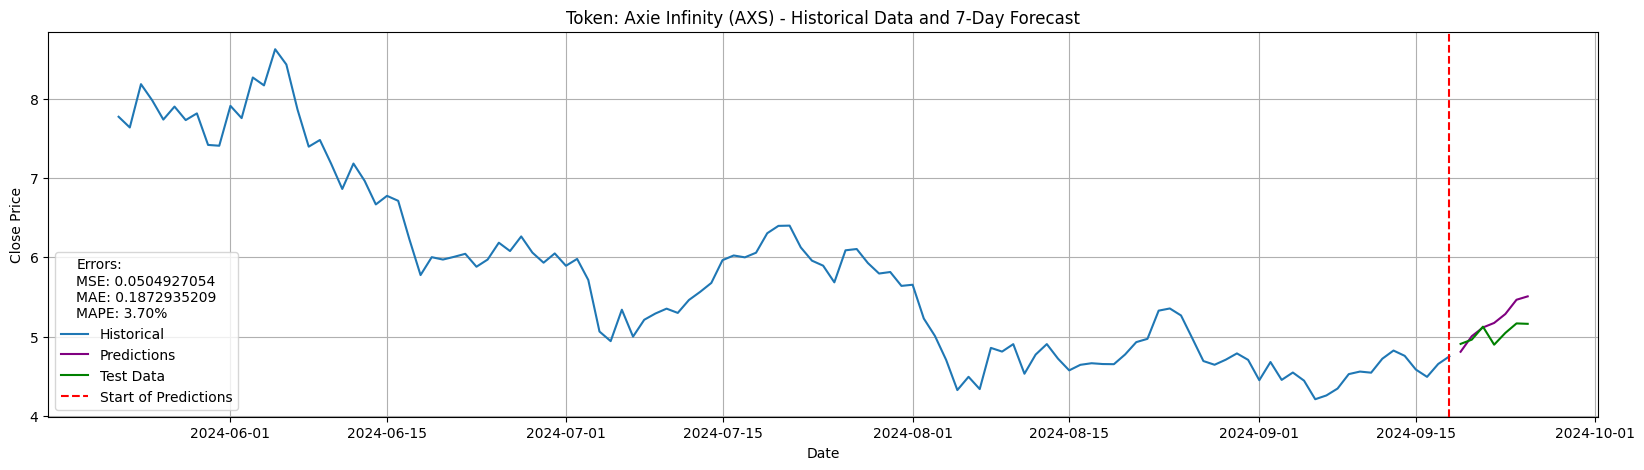

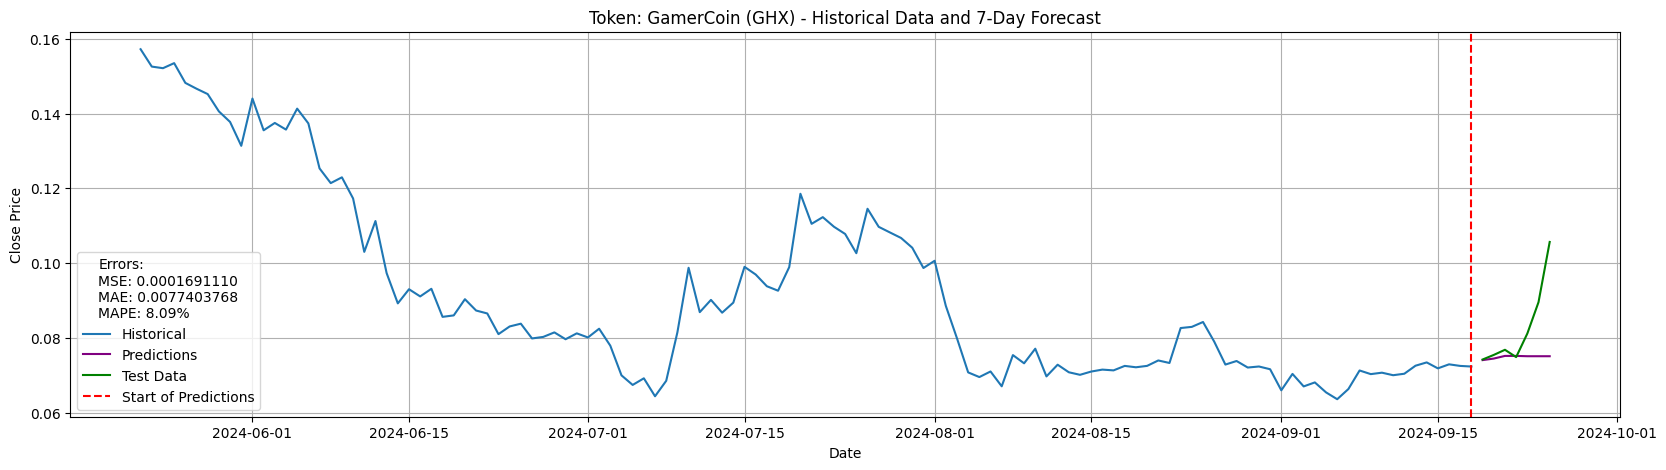

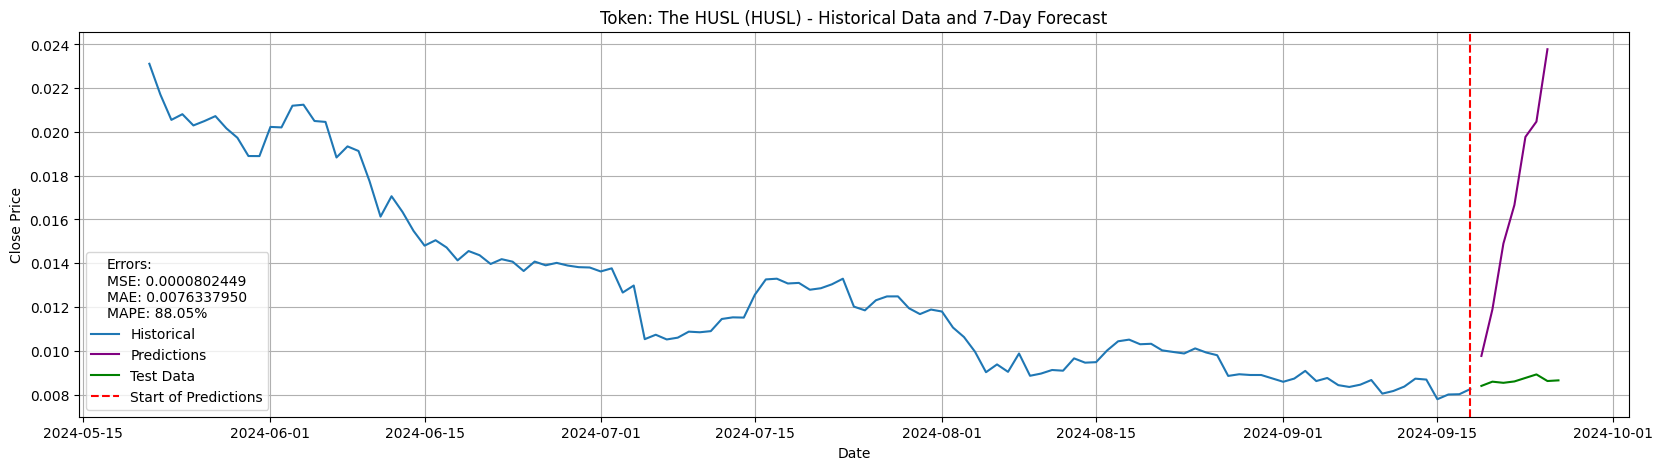

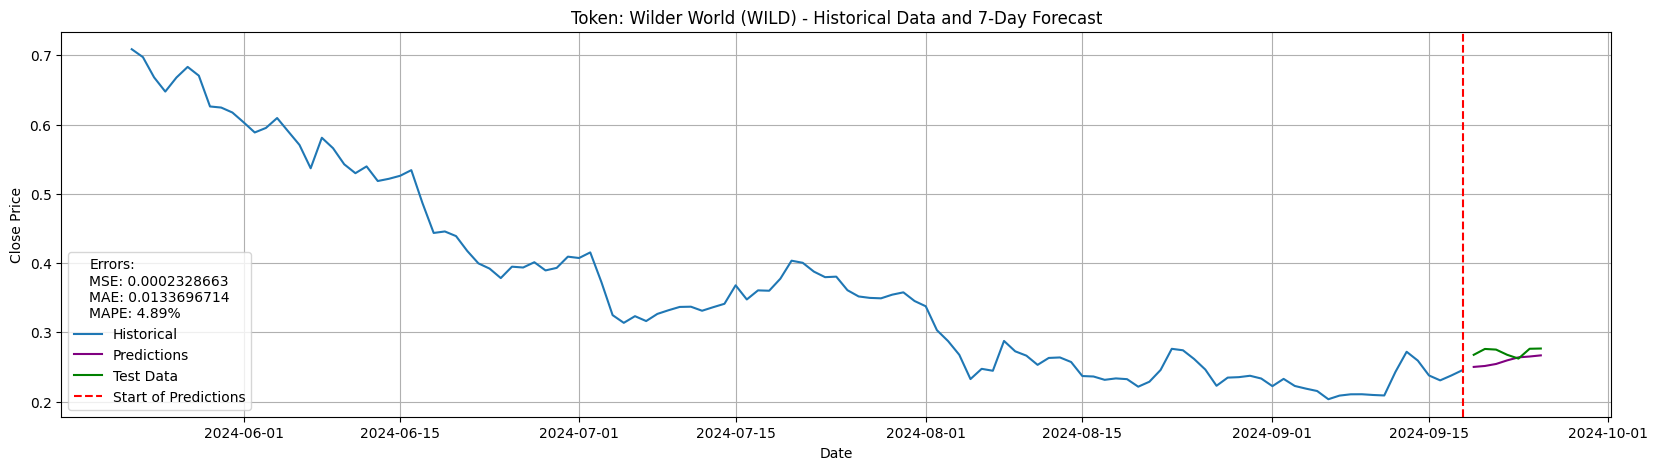

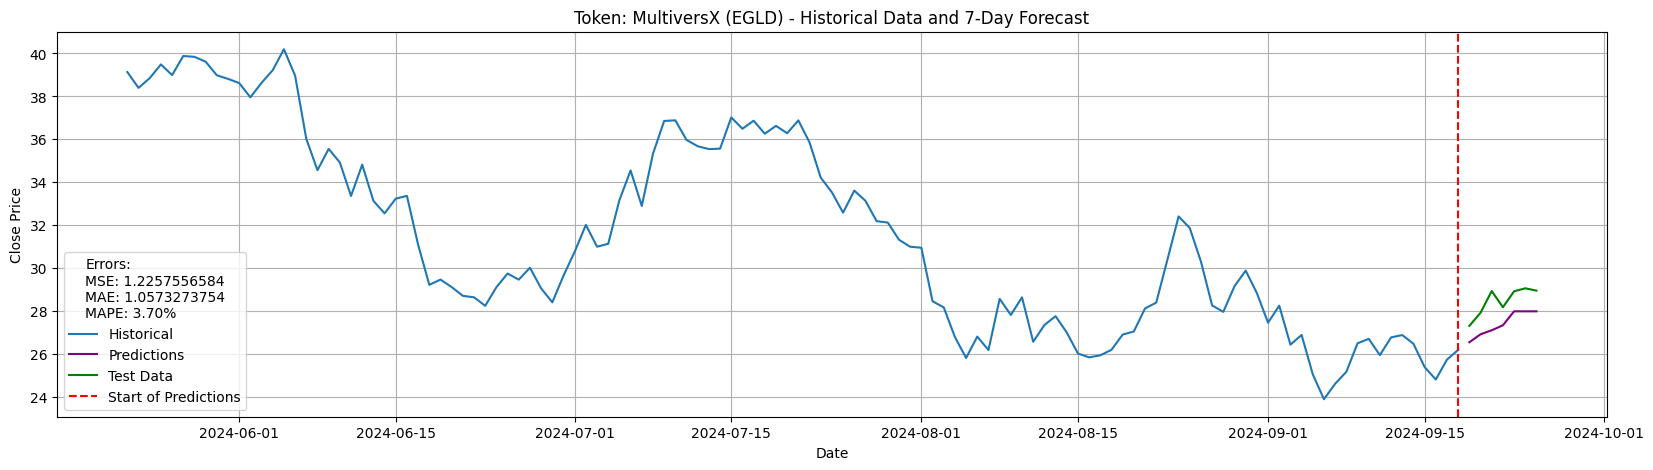

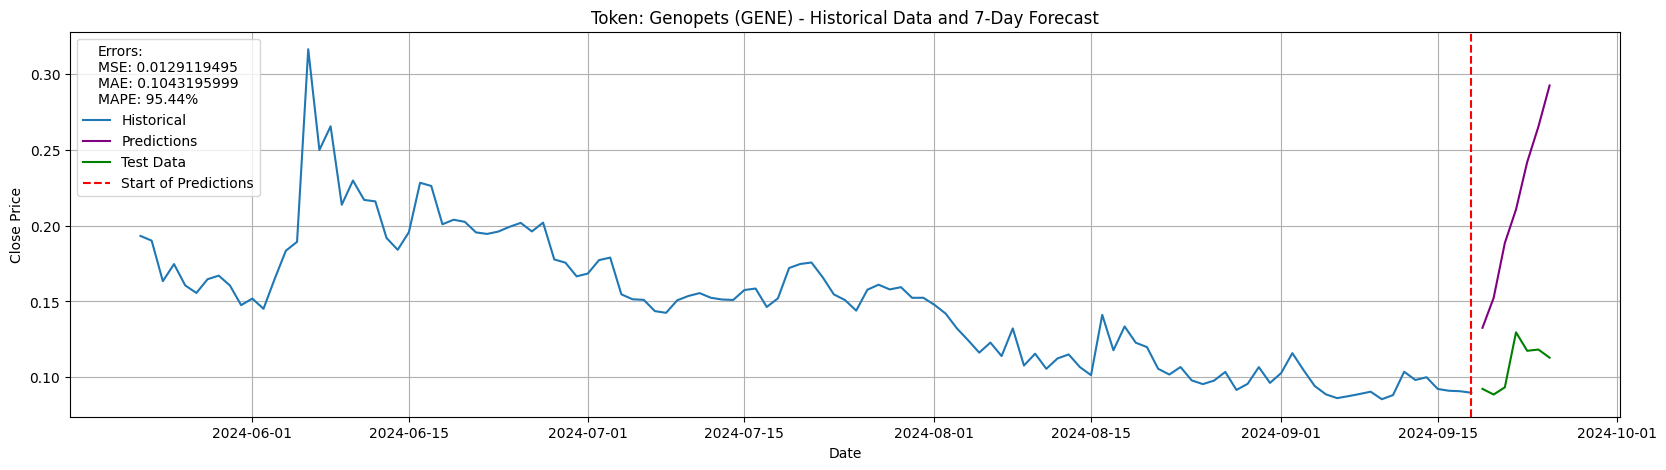

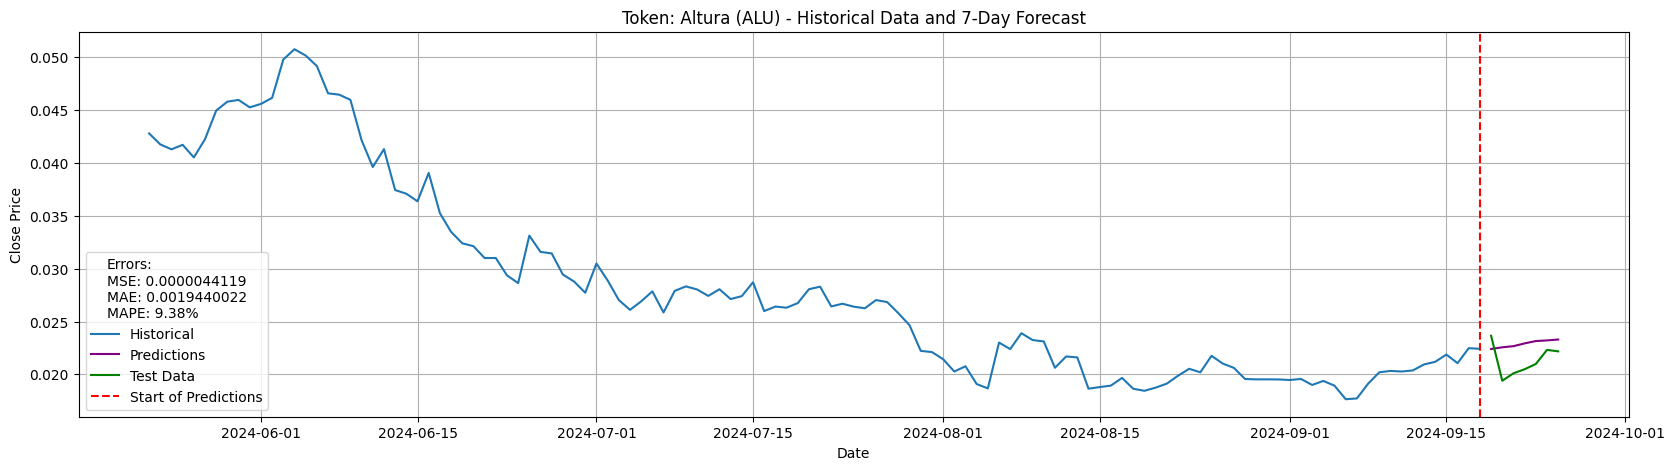

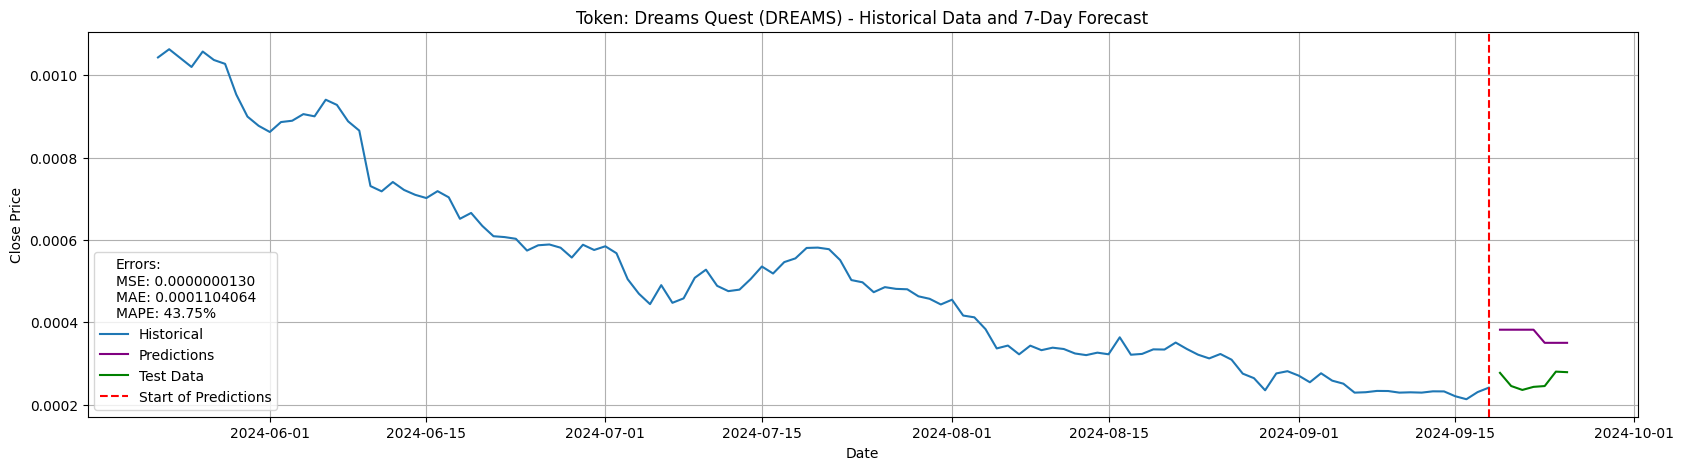

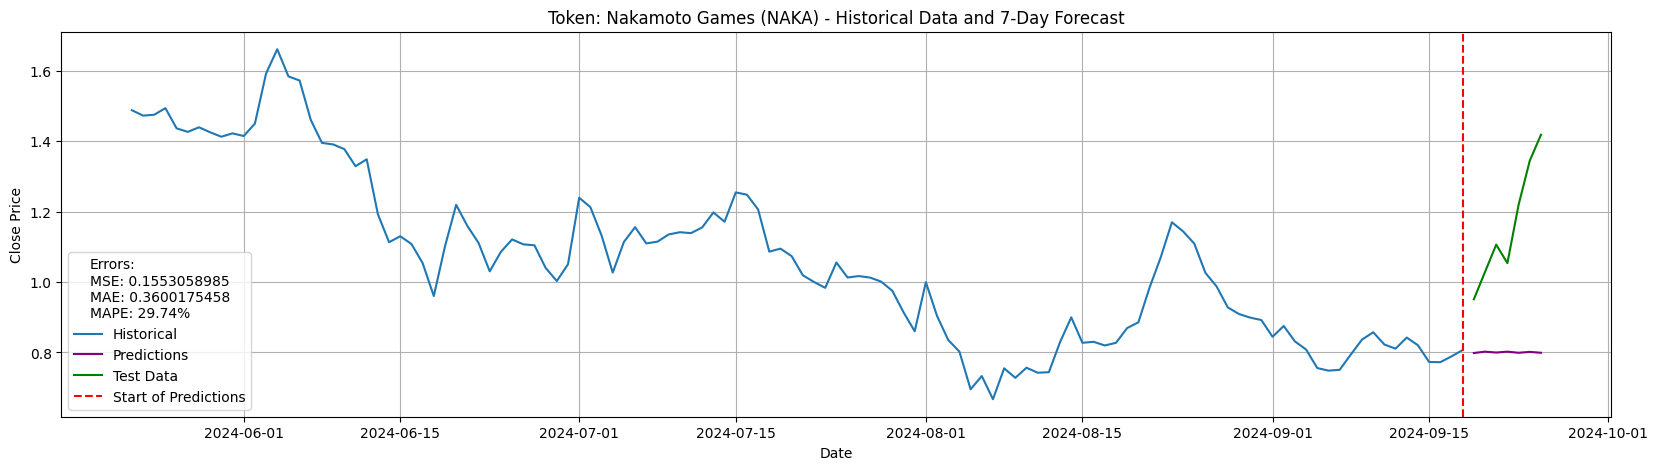

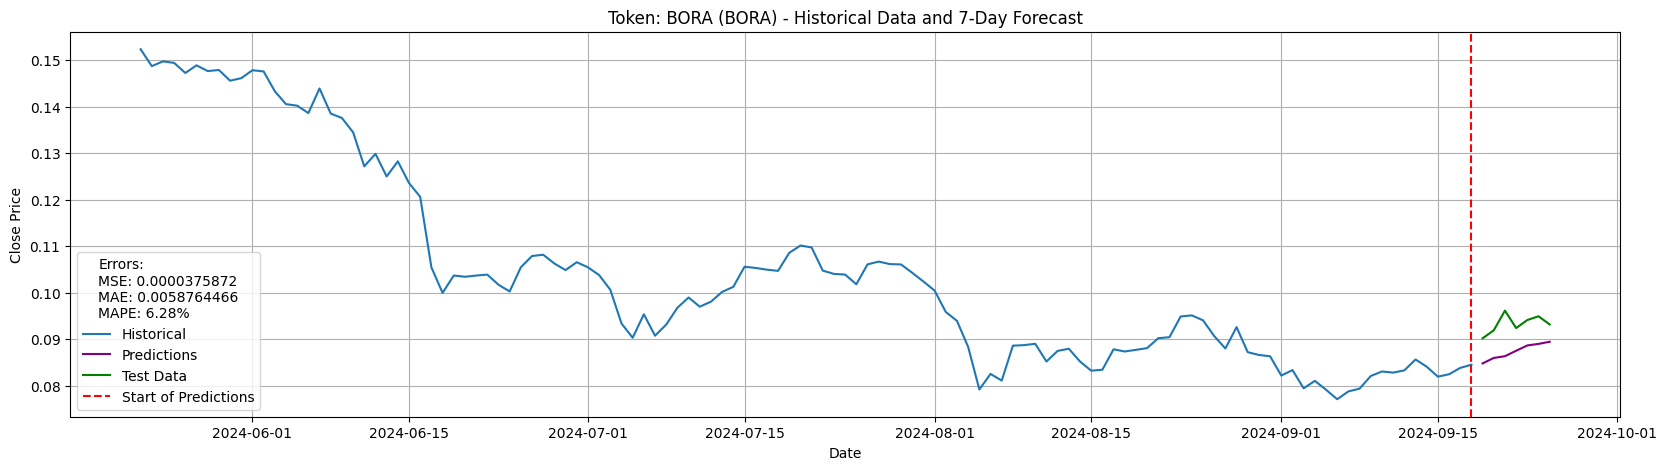

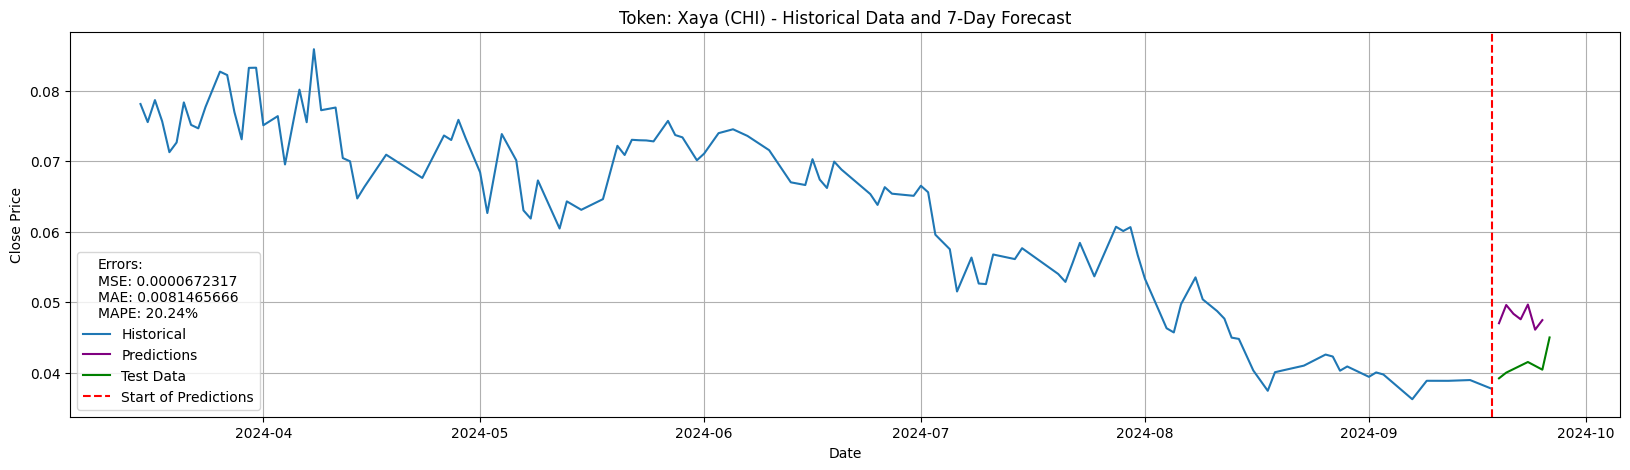

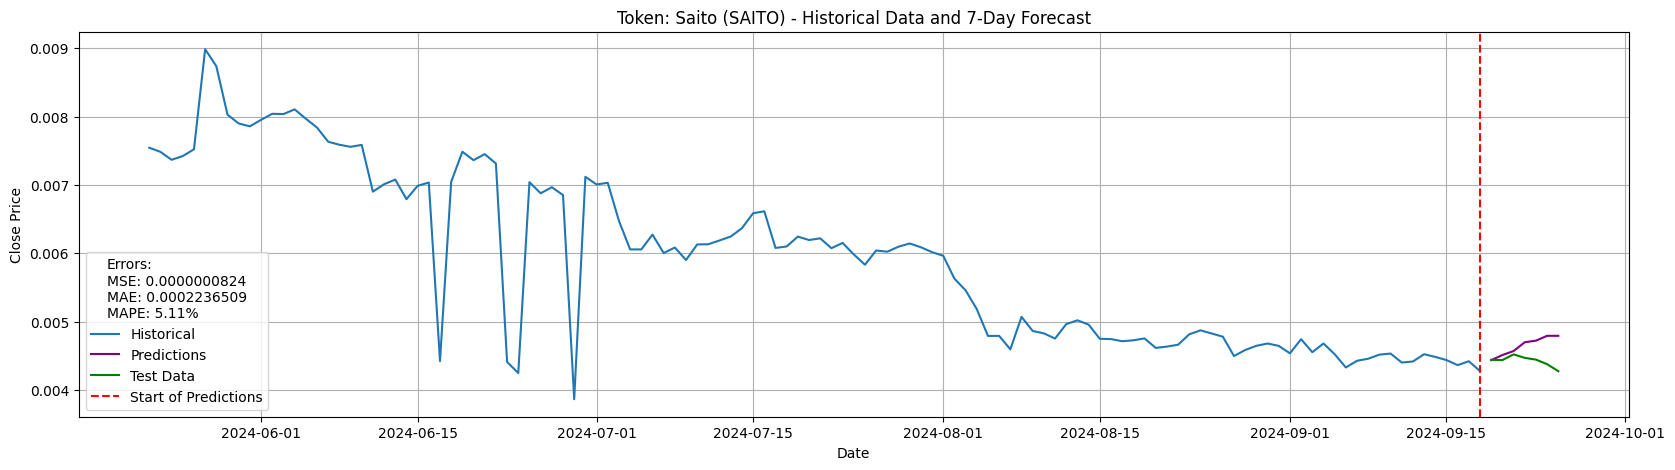

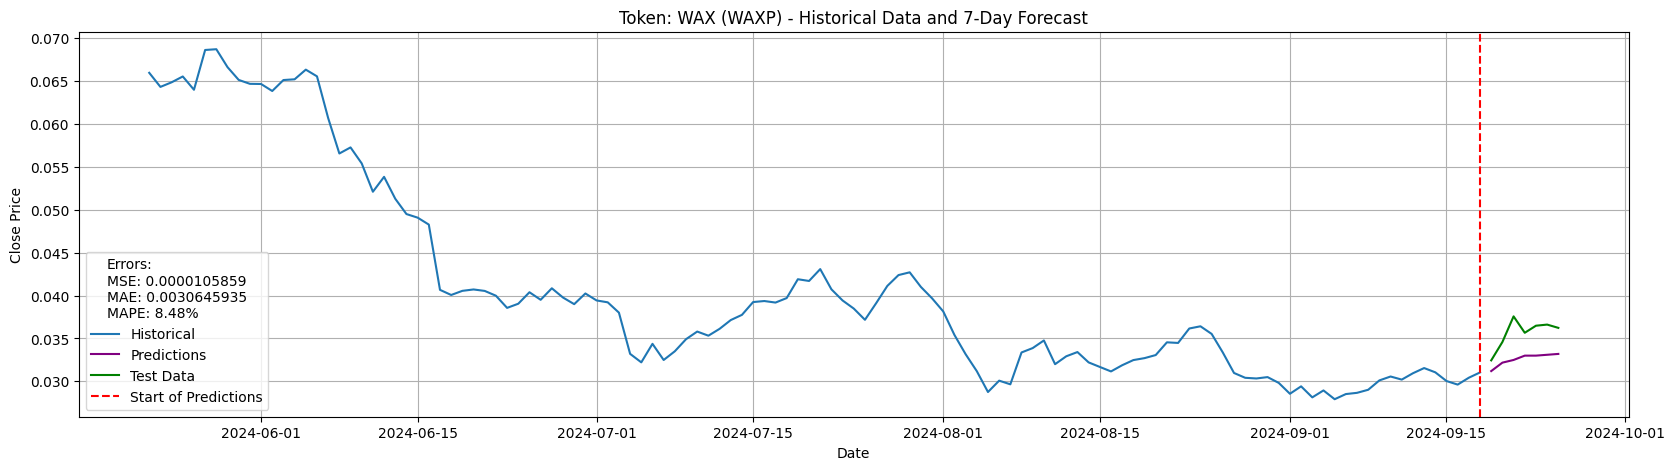

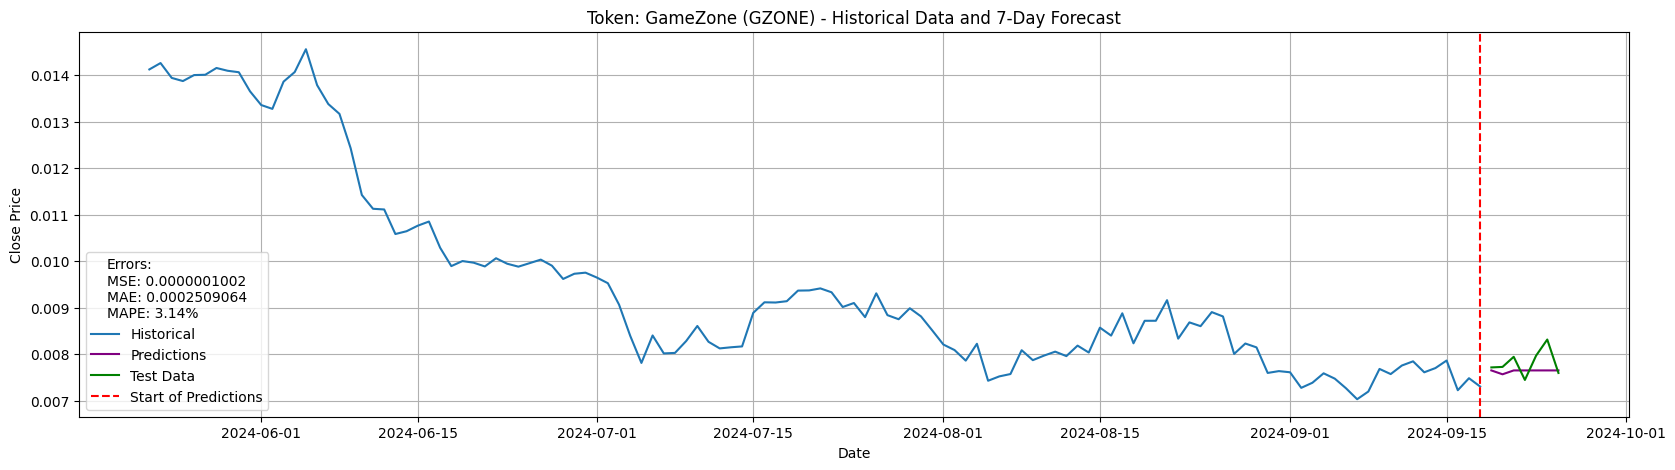

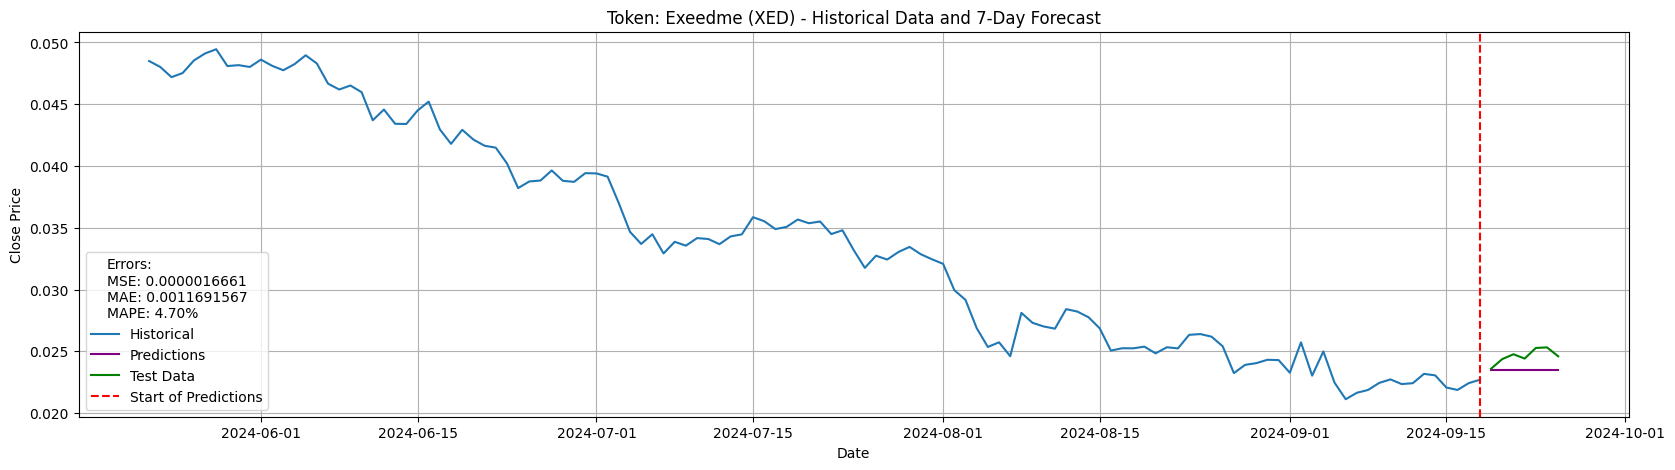

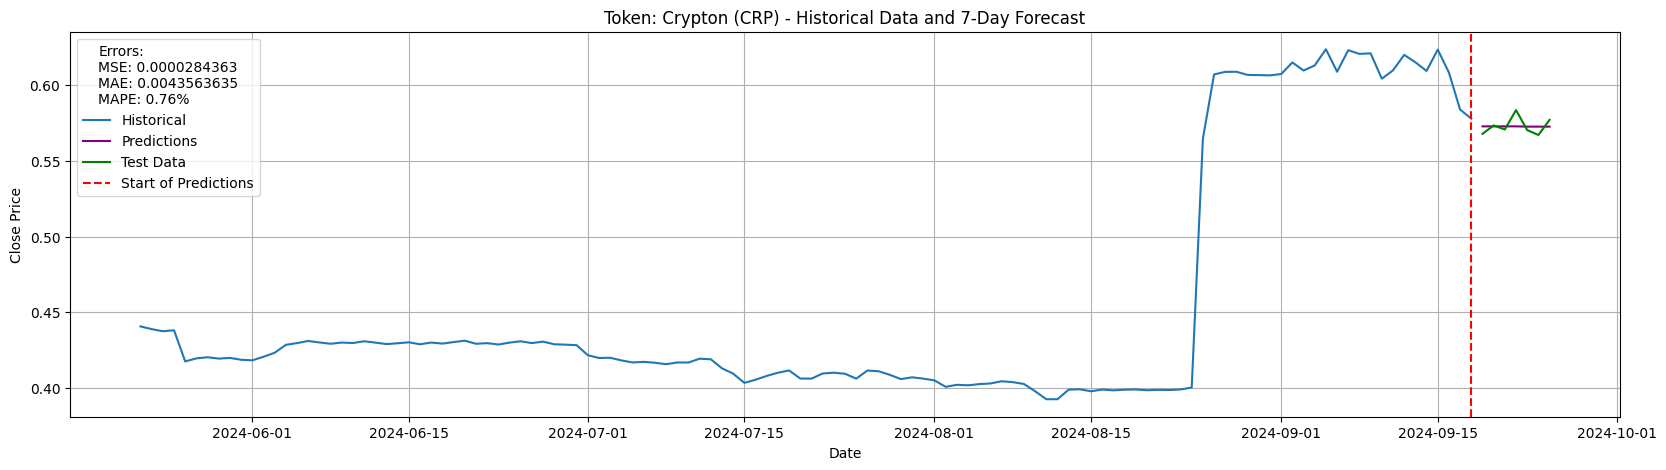

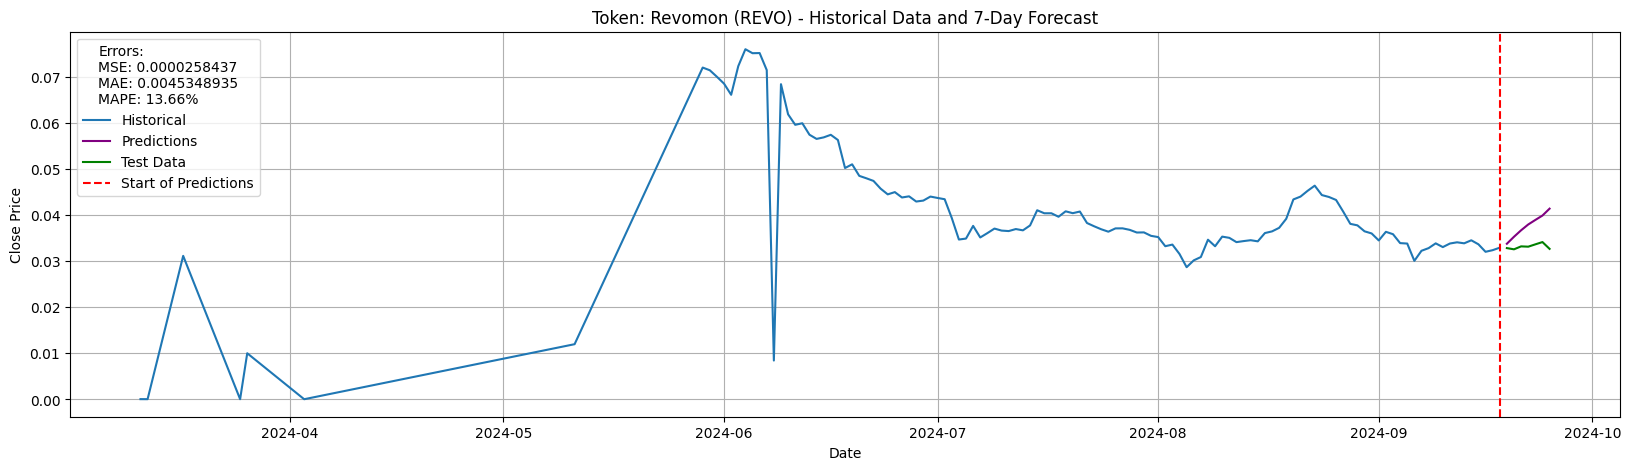

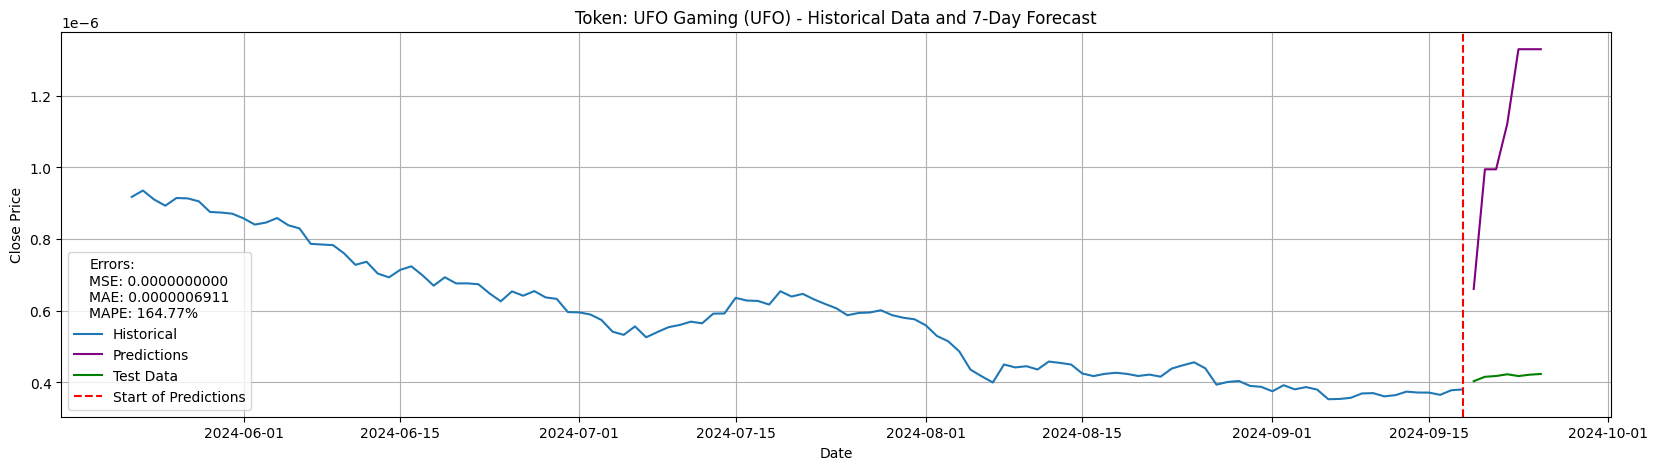

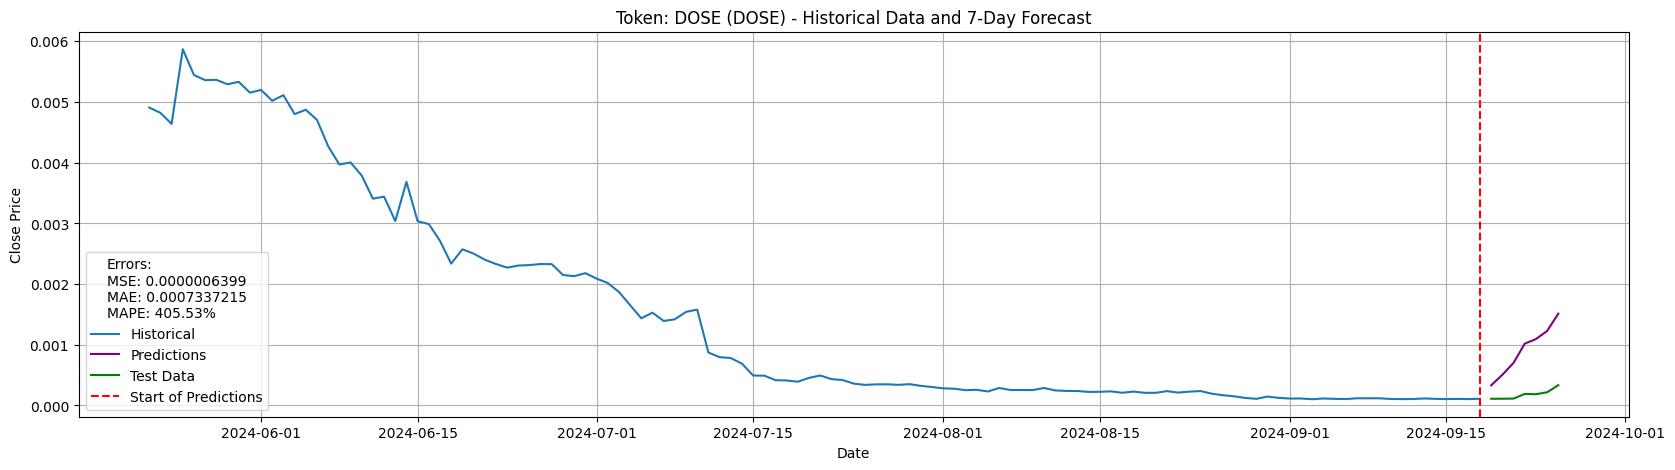

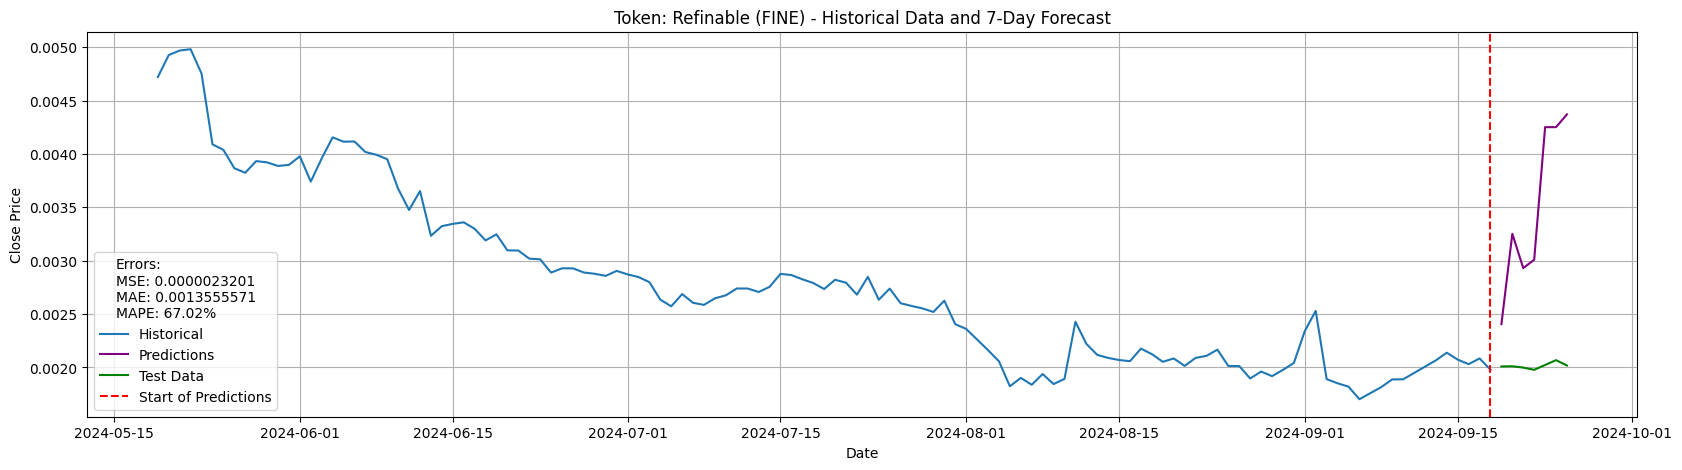

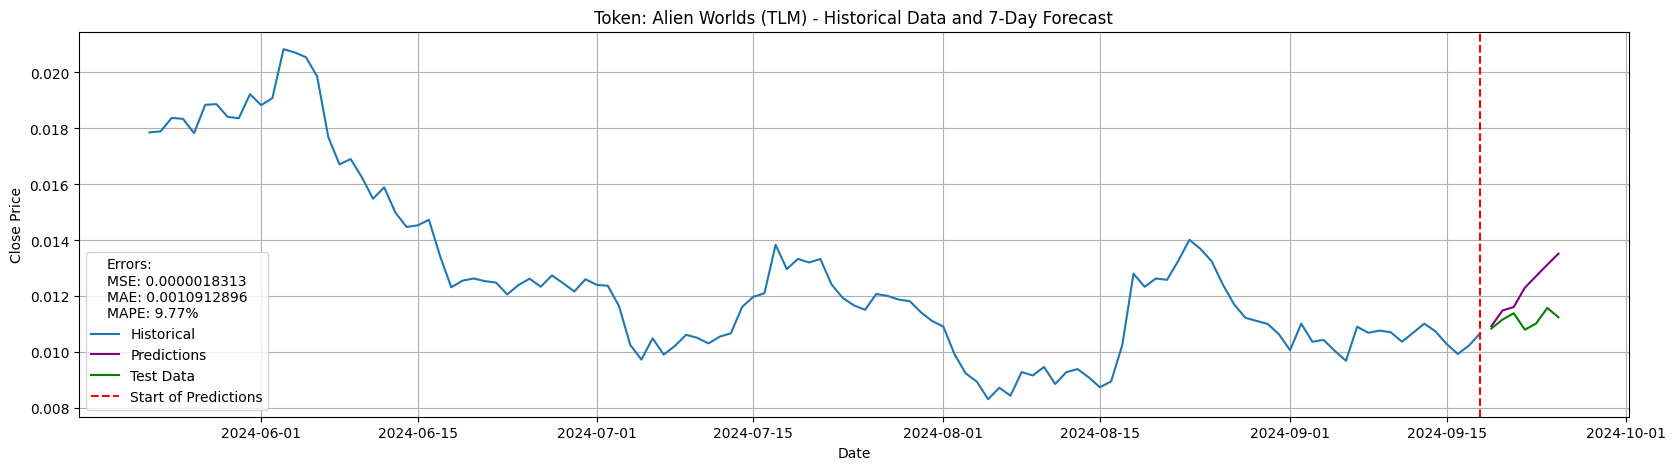

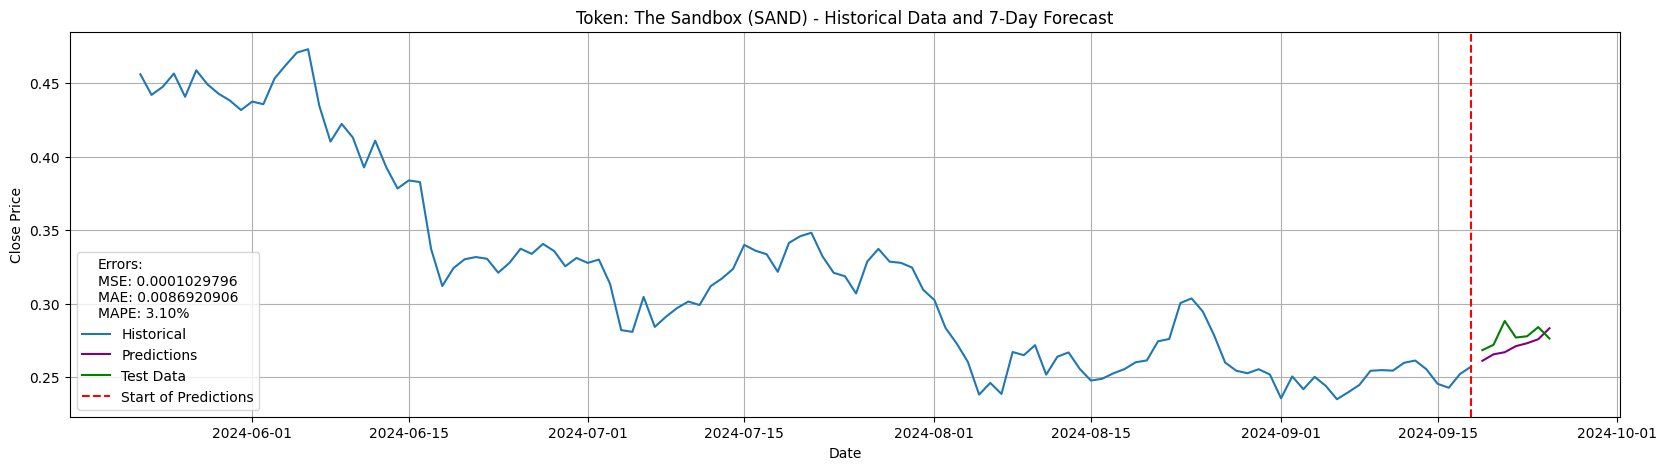

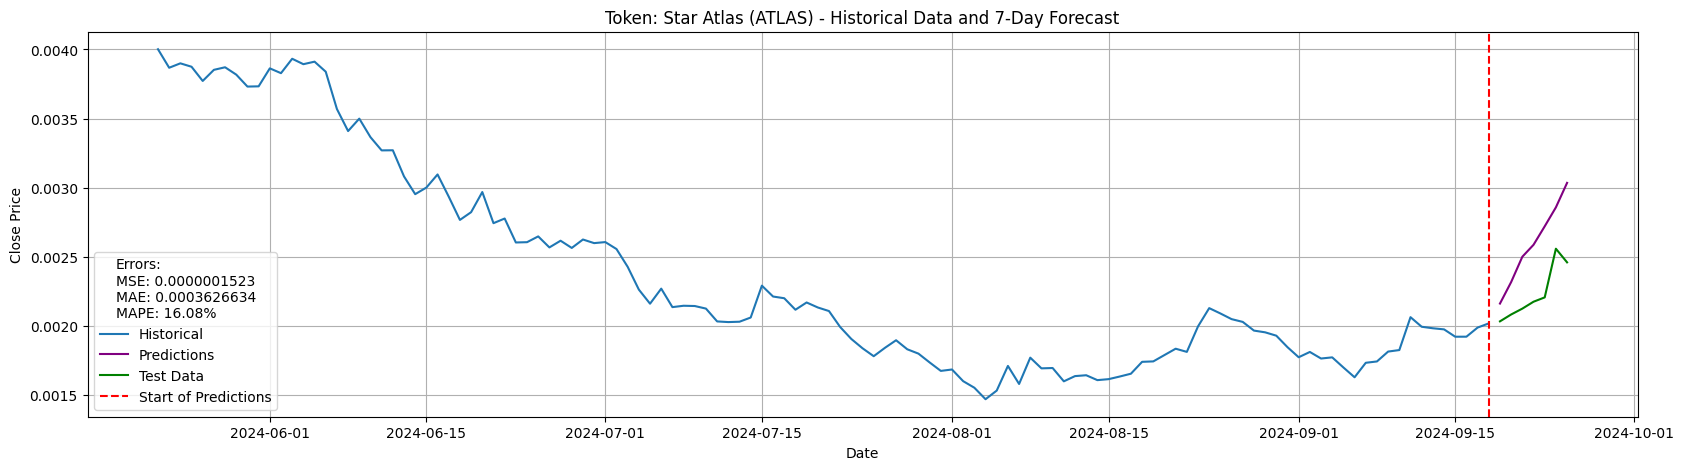

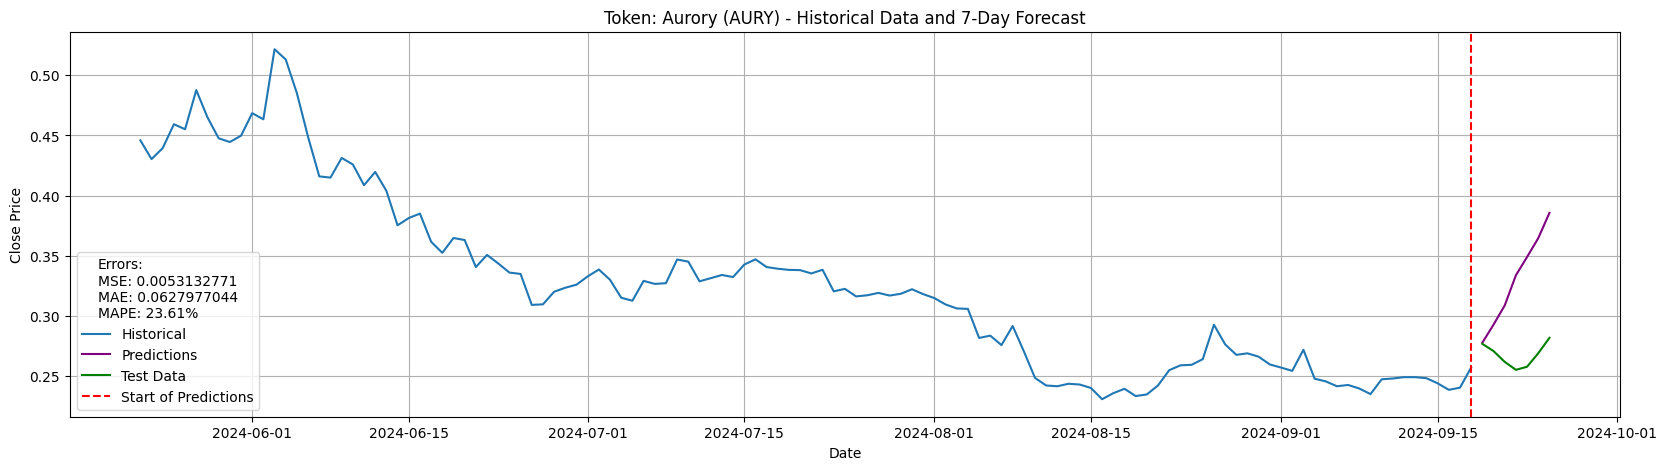

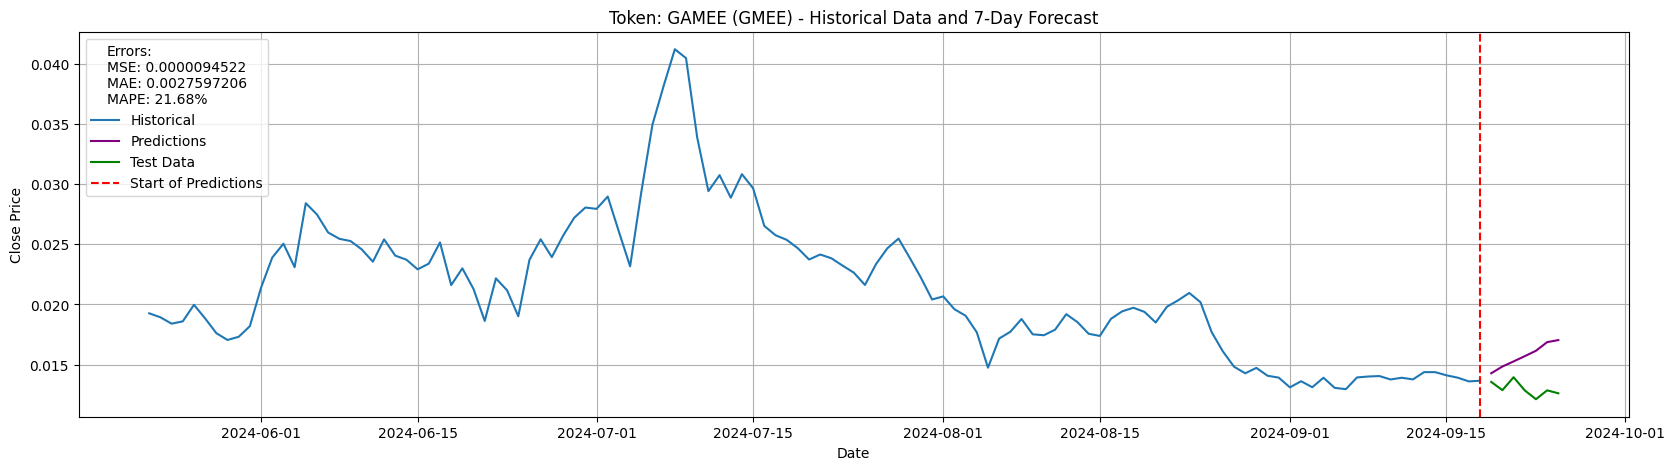

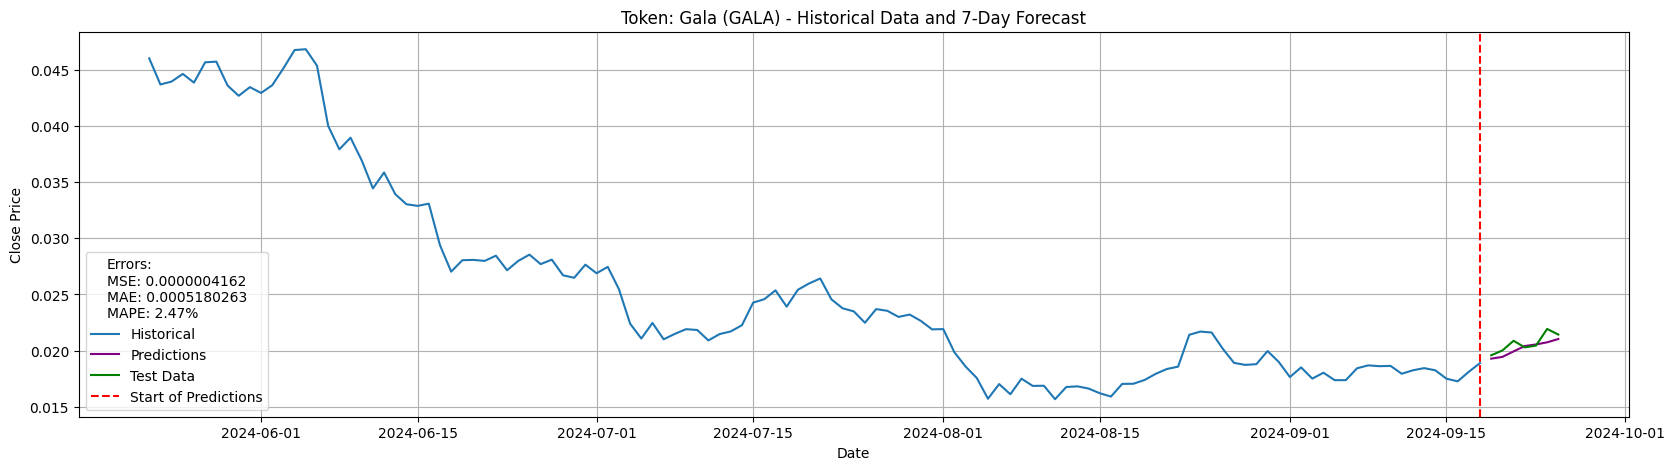

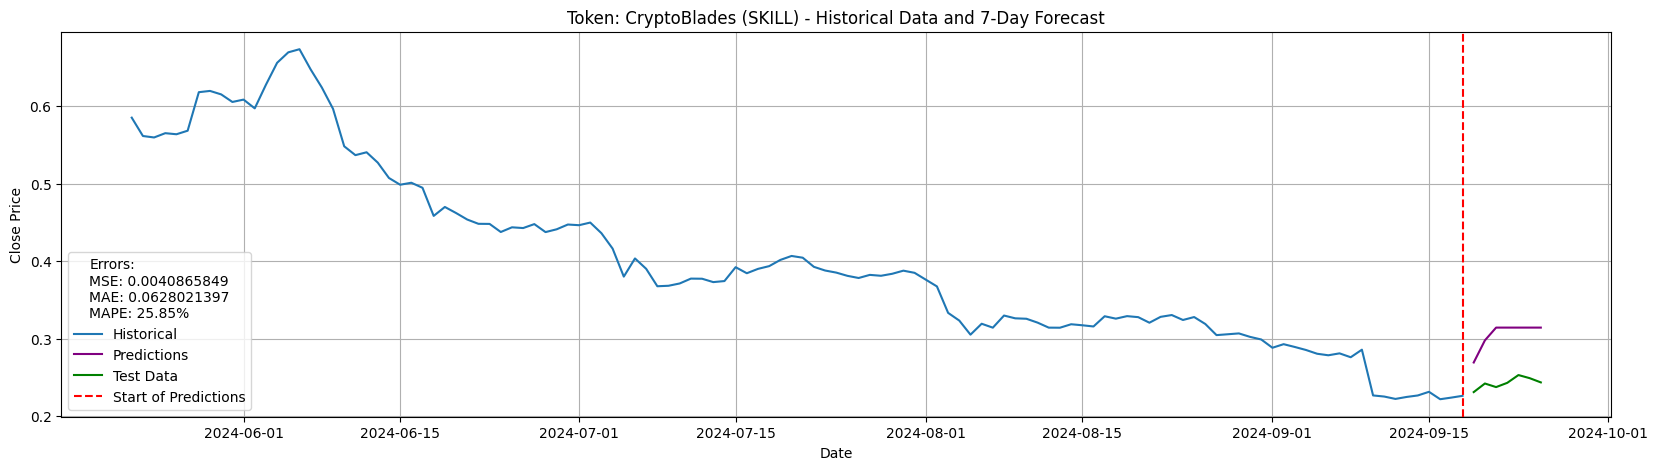

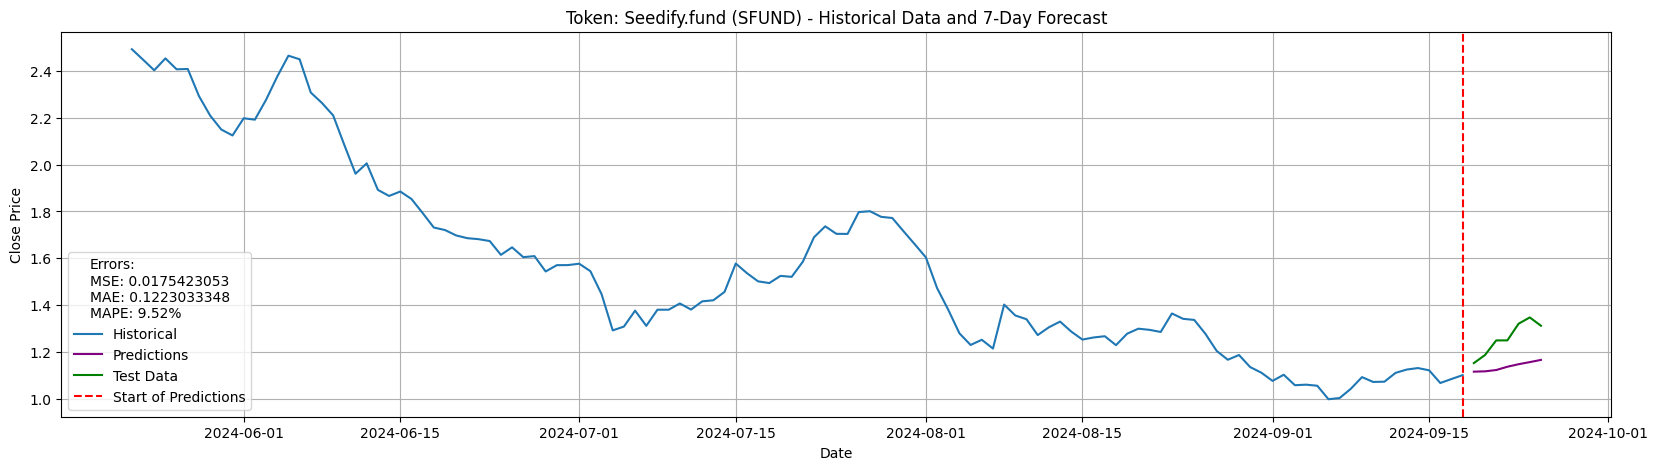

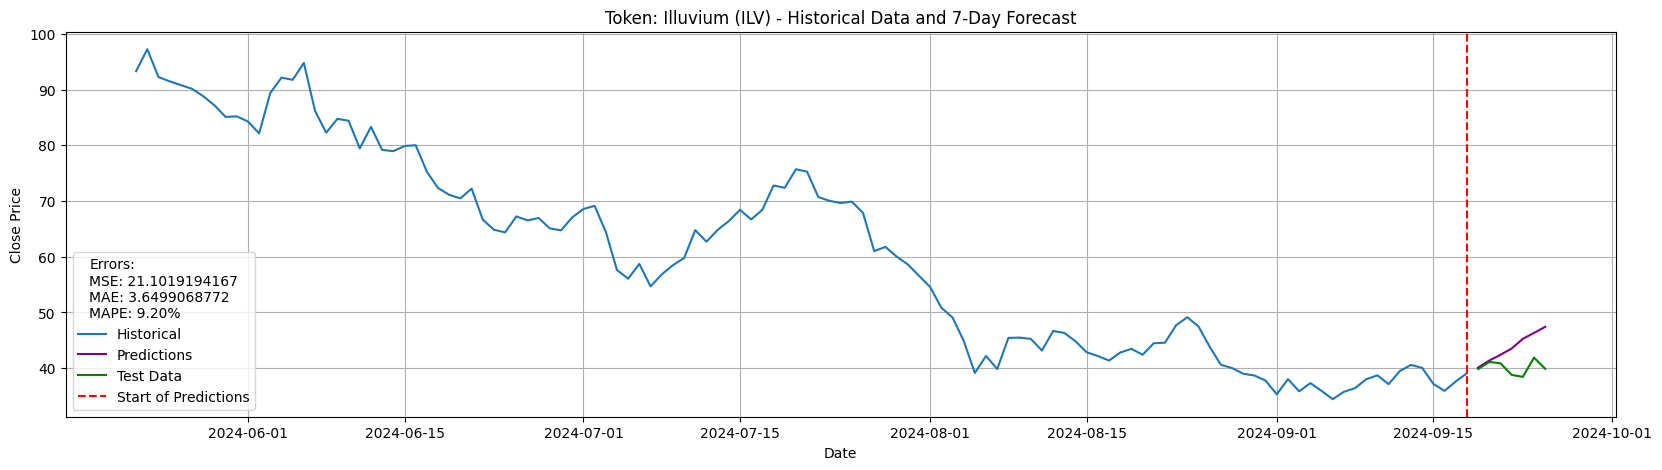

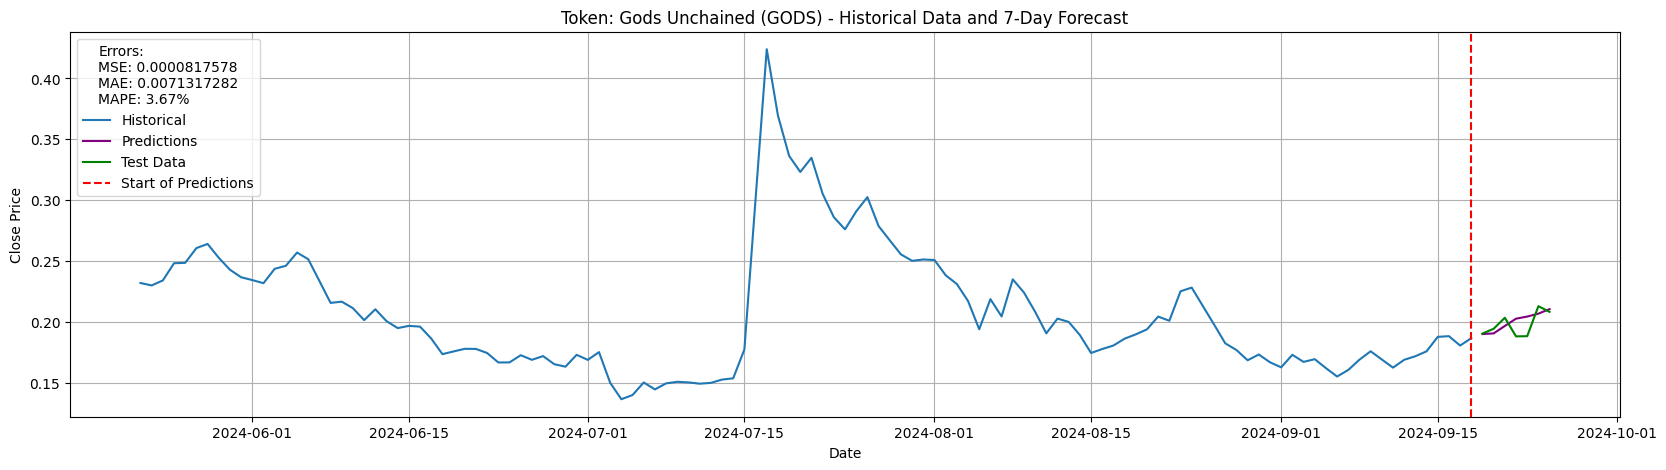

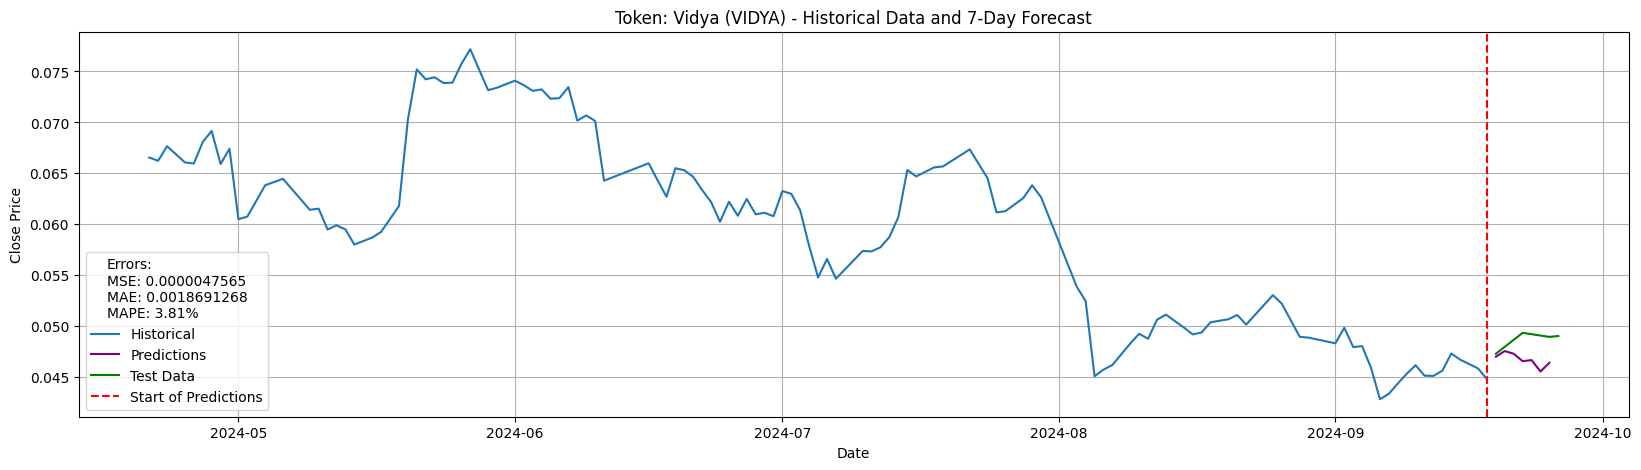

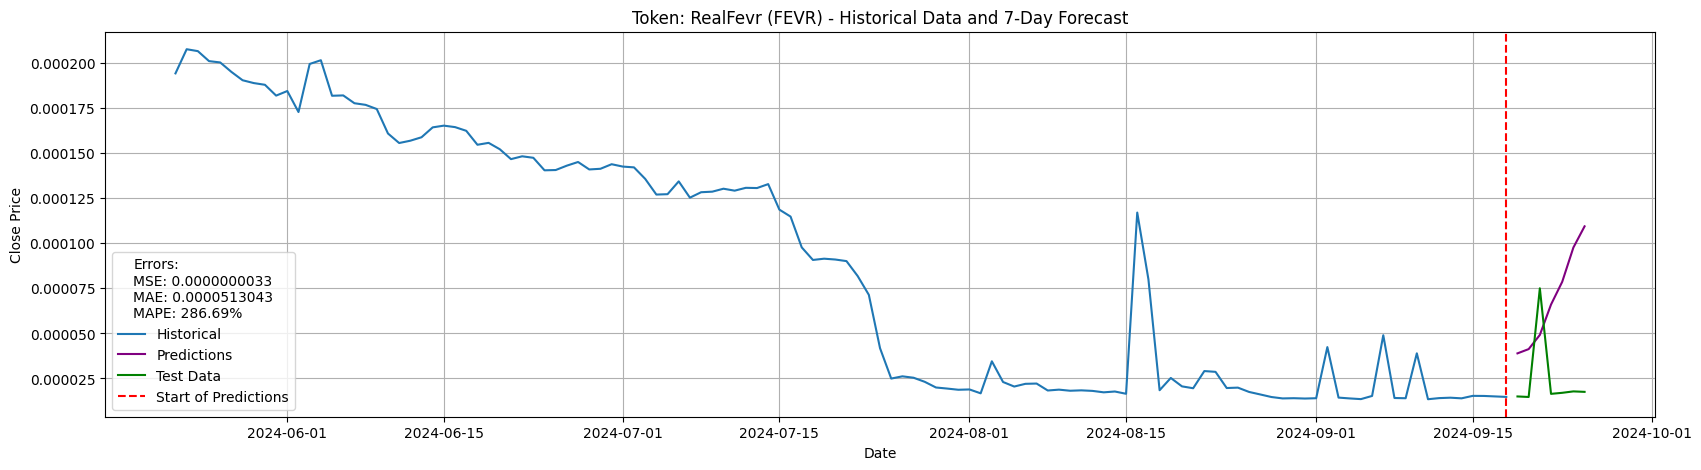

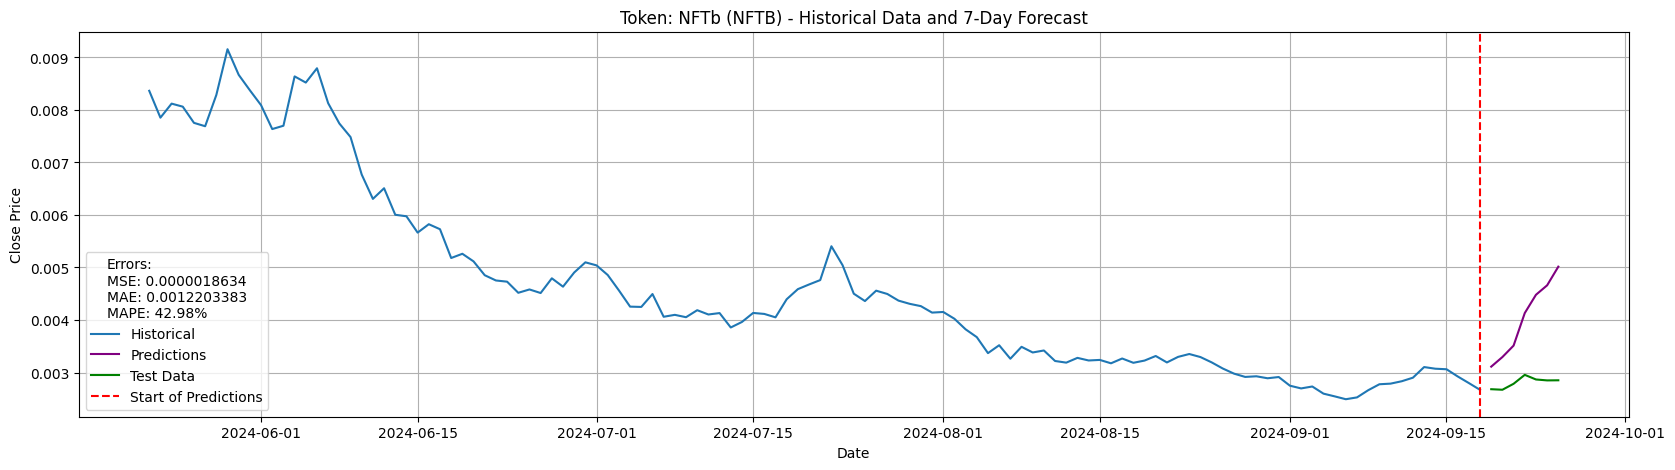

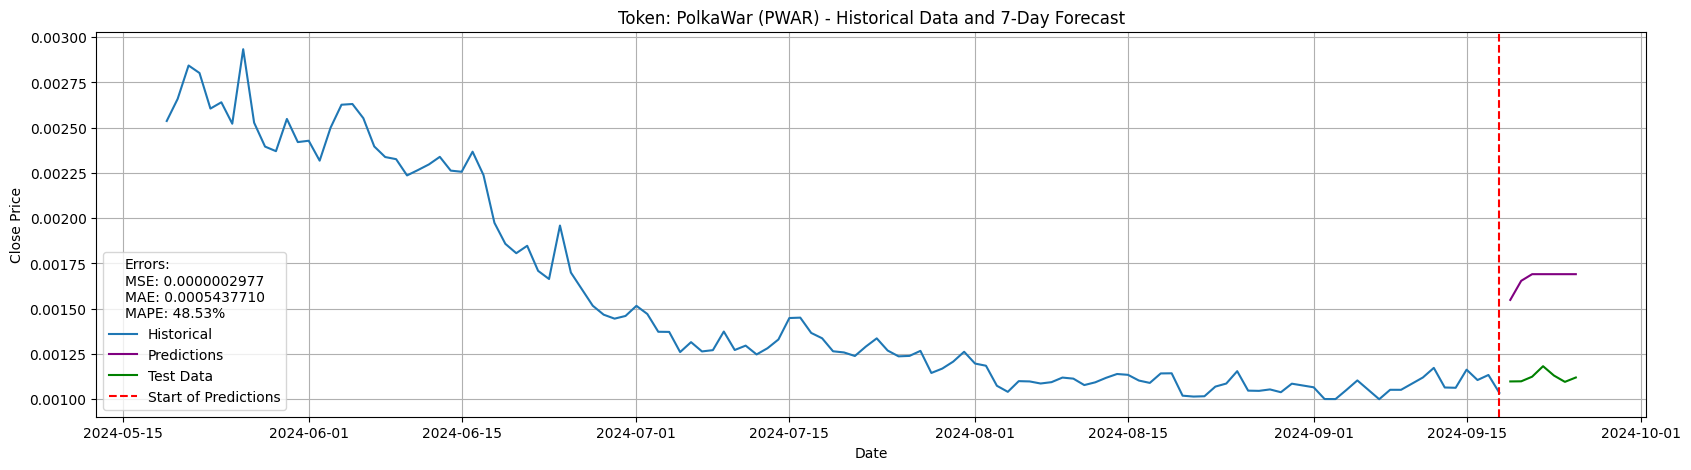

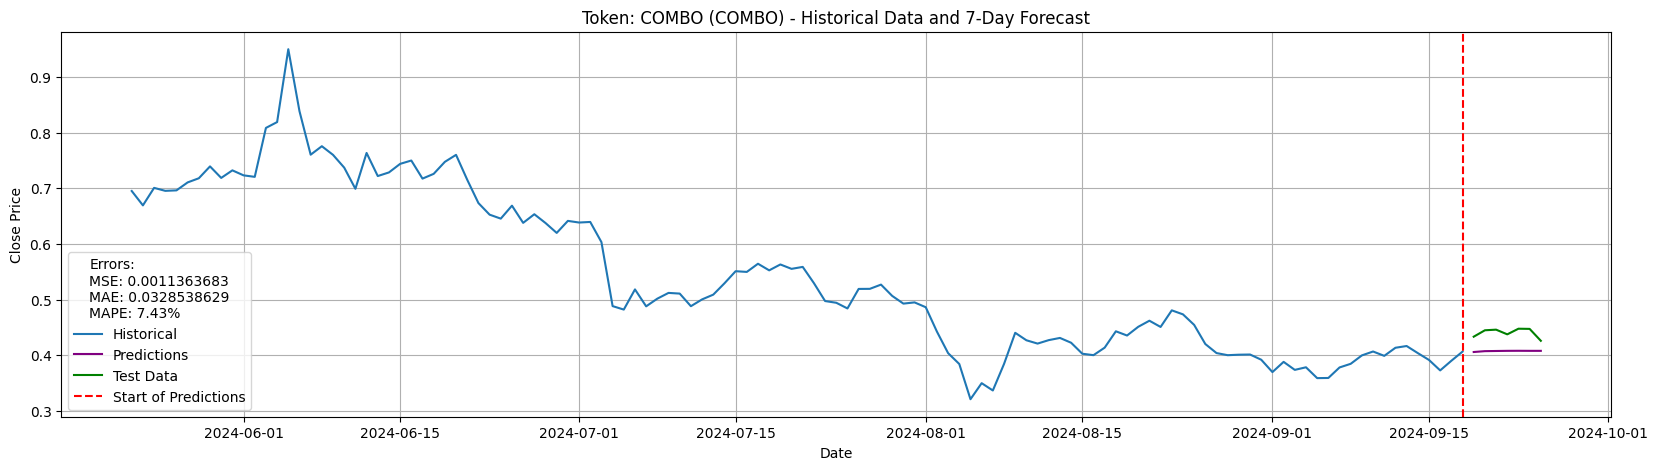

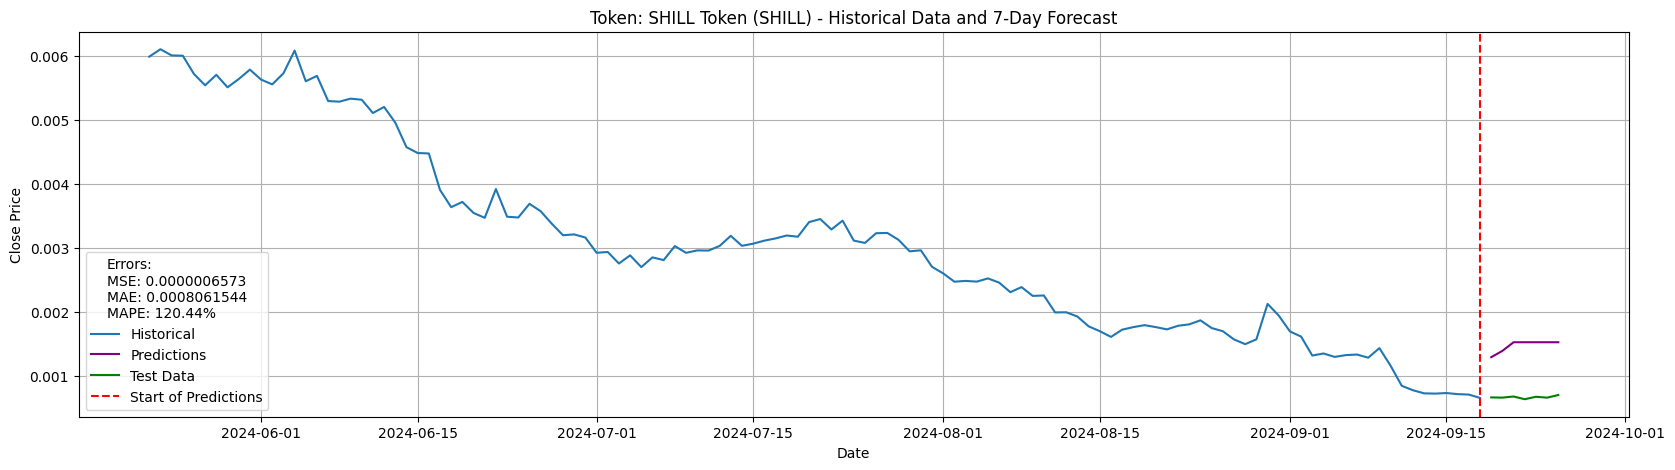

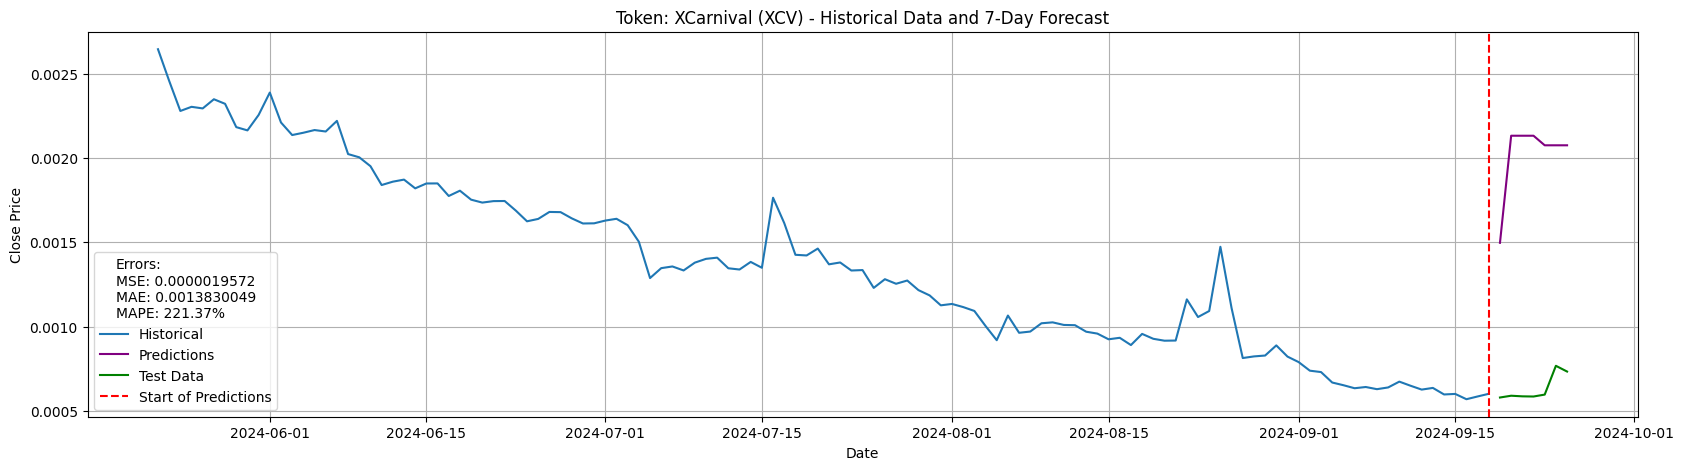

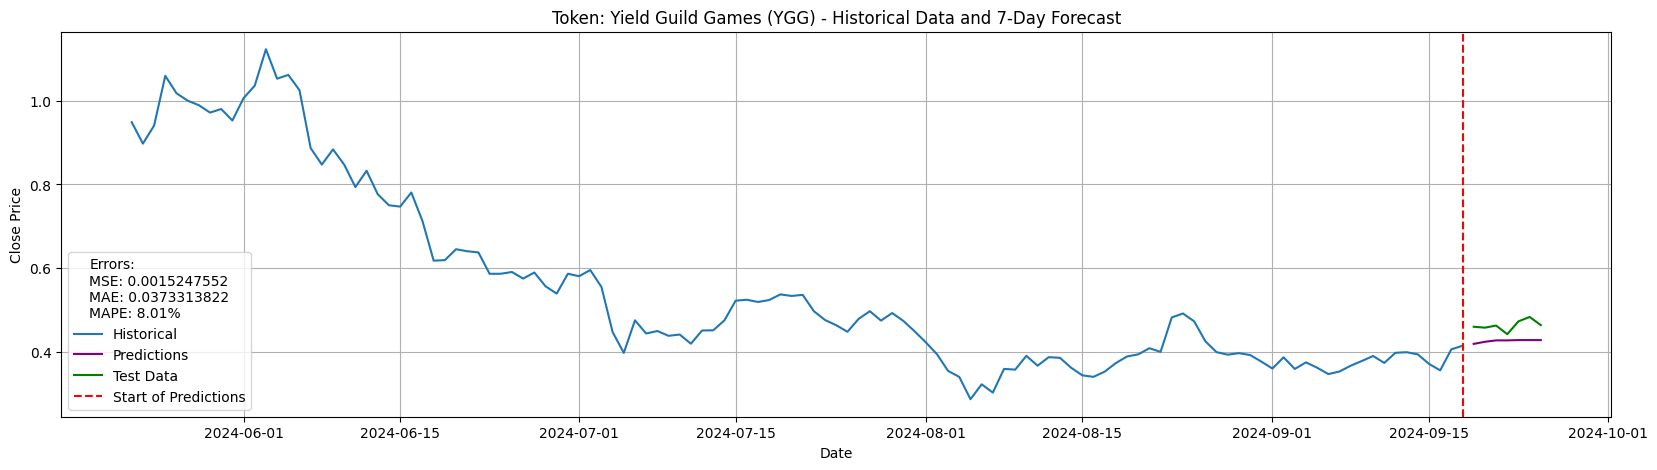

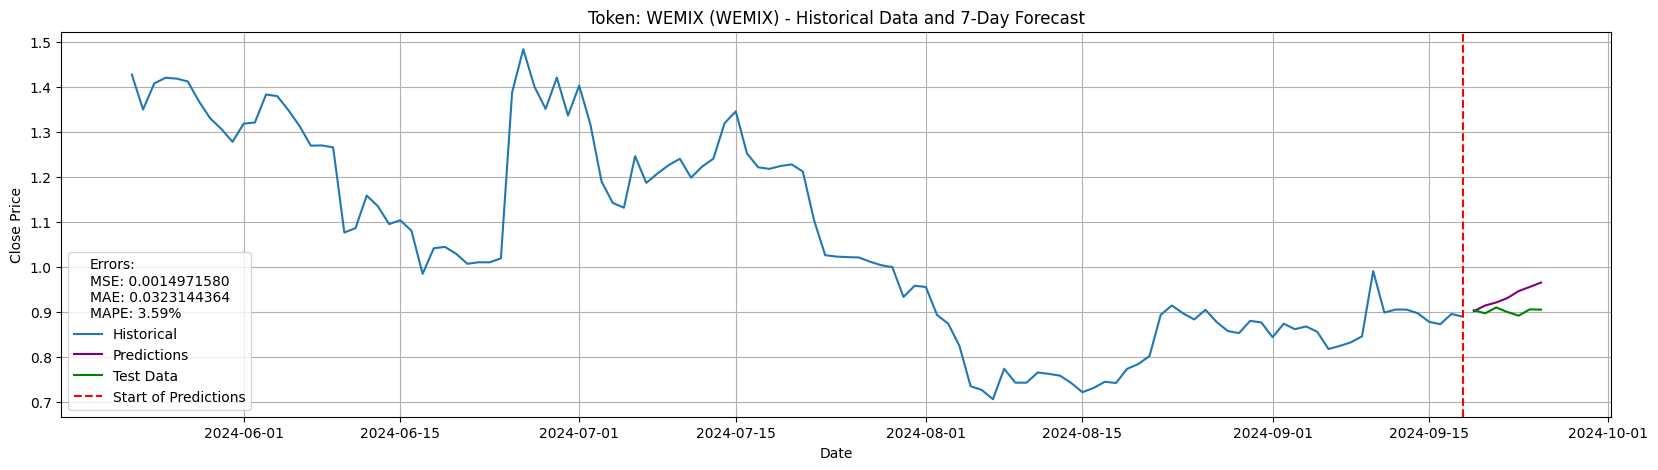

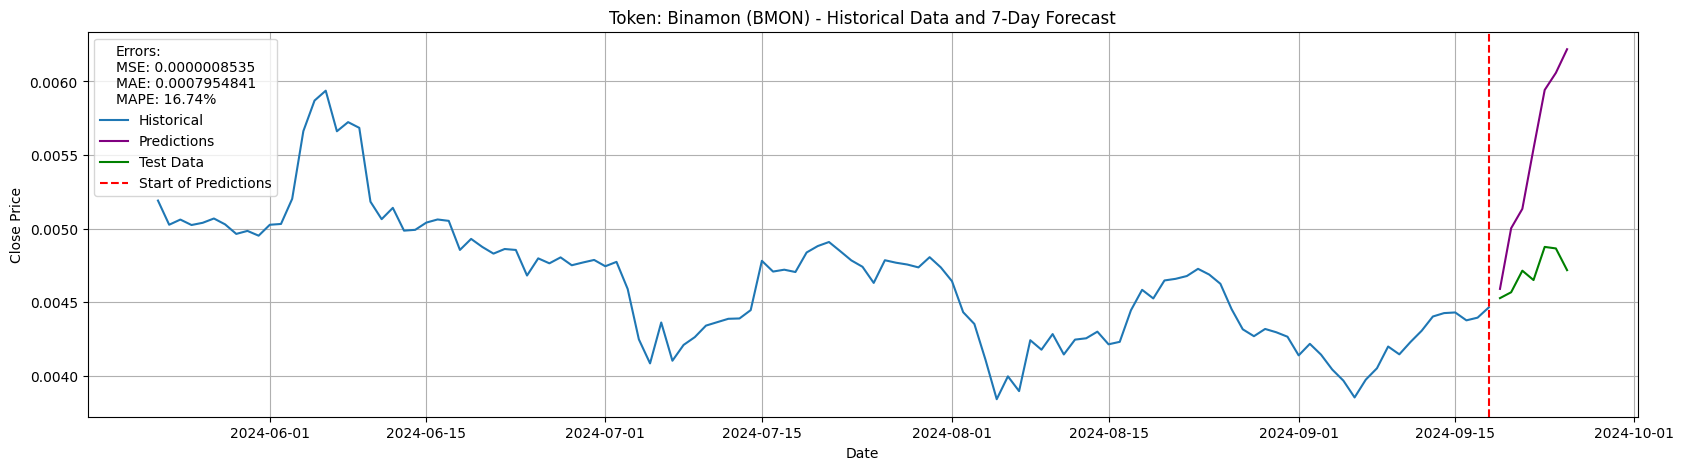

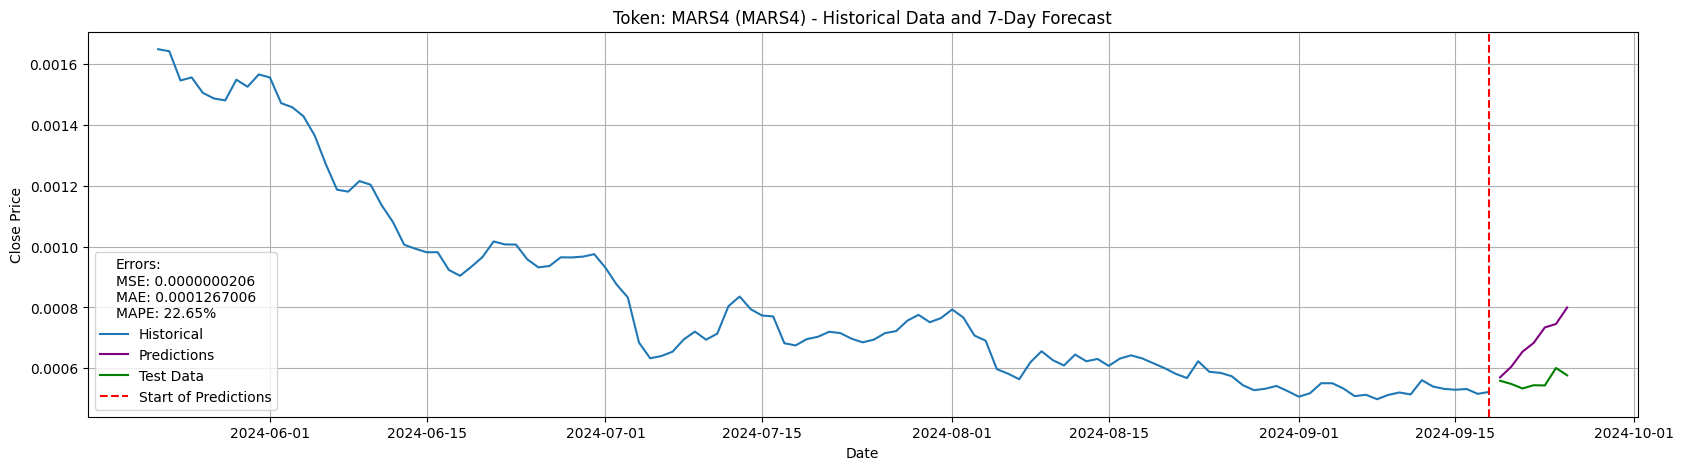

In [14]:
u.plot_predictions(train_data=gaming_obj.og_train, predictions_x_days=gaming_obj.og_pred, test_data=gaming_obj.og_test, last_data_points=120)

In [ ]:
u.plot_predictions(train_data=ai_obj.og_train, predictions_x_days=ai_obj.og_pred, test_data=ai_obj.og_test, last_data_points=60)

In [ ]:
u.plot_predictions(train_data=rwa_obj.og_train, predictions_x_days=rwa_obj.og_pred, test_data=rwa_obj.og_test, last_data_points=60)

In [ ]:
u.plot_predictions(train_data=meme_obj.og_train, predictions_x_days=meme_obj.og_pred, test_data=meme_obj.og_test, last_data_points=60)